In [1]:
import pandas as pd

import sqlite3
import pandas as pd

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)


# Create db connection.
cnx = sqlite3.connect('data/database.sqlite')





seasons = ['2015/2016']
leagues_id = [21518]


In [2]:
## Cleaning names of teams

import stringdist

# Normalize names 
def normalize_team_names(y):
    teams = []
    for t in list(y):
        tt = t.lower().split()
        rem = []
        cont=0
        #print(tt)
        for el in tt:
            cont +=1
            if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']: 
                if cont < len(tt):
                    tt[cont]='atl'+tt[cont]
            if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
                rem.append(el)
            
                #print(tt)
        if rem != []:
            for r in rem:
                tt.remove(r)
        
        if len(tt)>1:
            if len(tt[0])>len(tt[1]):
                t = tt[0]
            else:
                t = tt[1]
        else:
            t=tt[0]
        #print(t)  
        teams.append(t)
    return teams

#Change name x for the most similar name in the teams_normalized list.
def func(x,teams_normalized):
    dist =0
    distmin=10
    xt = x.lower().split()
    rem = []
    cont=0
    for el in xt:
        cont +=1
        if el in ['athletico','atletico','athlético','atlético','atl','ath','athletic']:
            if cont < len(xt):
                xt[cont]='atl'+xt[cont]
        if el in ['manchester','man','sporting','sp','deportivo','la','de','real','fc','cf','ud','las','cd','balompié','rc','de','athletico','atletico','athlético','atlético','atl','ath','athletic']:
            rem.append(el)
    if rem != []:
        for r in rem:
                xt.remove(r)
                


    if len(xt)>1:
        if len(xt[0])>len(xt[1]):
            x = xt[0]
        else:
            x = xt[1]
    else:
        x=xt[0]

    
    for t in list(teams_normalized):
        dist = stringdist.levenshtein(x, t)
        #print(t)
        if dist < distmin:
            #print('................')
            #print(x)
            #print(t)
            #print(dist)
            #print('................')
            distmin = dist
            team =t
    return team



def convert_to(df,type_to_convert, all_categorical = False,columns = 'None'):
 
    if all_categorical == True:
        categoric_types = df.select_dtypes(include=['object','category']).columns
        if categoric_types.empty:
            print('No object types in the dataframe to be converted')
            return df
        else:
            if 'labels' in categoric_types:
                categoric_types.remove('labels')
            df[categoric_types] = df[categoric_types].astype('category')
            columns = categoric_types
        
    else:
        df[columns] = df[columns].astype('category')
        
        
    if type_to_convert == 'labelling':
        for column in columns:
            df[column] = df[column].cat.codes
    elif type_to_convert == 'onehot':
        for column in columns:
            print(columns)
            df= pd.get_dummies(df, columns=[column])             
      
    return df

def convert_to_standard_team_names(cnx, league_id, season):

    #.......... df_matches ..........
    
    #Read matches from the season and league specified.
    df_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id = (?) AND season = (?)", cnx, params=(league_id,season,)) 
    print(f'The shape of df_matches of league:{league_id} and season:{season} is: {df_matches.shape}')

    #Drop columns with not useful information (html text), we will get this information from another dataset from football-data.co.uk
    df_matches = df_matches.drop(columns=['goal', 'shoton', 'shotoff','foulcommit', 'card', 'cross', 'corner', 'possession'])

    #Convert types
    df_matches['date'] = pd.to_datetime(df_matches['date'])
    df_matches['date'] = pd.to_datetime(df_matches['date'],format='%Y%m%d')
    df_matches['stage'] = df_matches['stage'].astype(int)
    
   #To merge data with the other dataset we need a common team id between both datasets. We are going to create a unique string identifier for team names named team_name_id.
    
    
    #In the df_matches we will first include a column with the name of the team extracted from the Team table by means of the team_api_id.
    df_Teams = pd.read_sql_query("SELECT * FROM Team ", cnx)
    df_Teams.head()
    

    # Manually change some names due its difficulty to be treated for our string name procedure.
    df_Teams.loc[df_Teams['team_long_name']=='Athletic Club de Bilbao','team_long_name'] = 'Athletic Bilbao'
    df_Teams.loc[df_Teams['team_long_name']=='Real Sporting de Gijón','team_long_name'] = 'Sporting Gijon'
    
    df_Teams.loc[df_Teams['team_long_name']=='West Bromwich Albion','team_long_name'] = 'West Brom'
    df_Teams.loc[df_Teams['team_long_name']=='West Ham United','team_long_name'] = 'West Ham'
    df_Teams.loc[df_Teams['team_long_name']=='Queens Park Rangers','team_long_name'] = 'QPR'
    df_Teams.loc[df_Teams['team_long_name']=='Stoke City','team_long_name'] = 'Stoke'
    df_Teams.loc[df_Teams['team_long_name']=='Hull City','team_long_name'] = 'Hull'
    df_Teams.loc[df_Teams['team_long_name']=='Bolton Wanderers','team_long_name'] = 'Bolton'
    df_Teams.loc[df_Teams['team_long_name']=='Wolverhampton Wanderers', 'team_long_name'] = 'Wolves'
    
    
    
    
    #First we normalize the names of the teams
    teams_normalized = normalize_team_names(df_Teams['team_long_name'])
    
    #Now we normalize the names of df_Teams 
    df_Teams['team_name_id']= df_Teams['team_long_name'].apply(lambda x: func(x,teams_normalized))

    
    #Now we will have to include names of the teams into de df_matches dataframe, for this we have to merge df_matches with df_Teams on the "team_api_id".
    #Since df_matches just have names of the 'home_team_api_id' and 'away_team_api_id', we will add a new column referring the corresponding teams as 'home_team_name_id' and 'away_team_name_id'.
    df_matches['home_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='home_team_api_id', right_on='team_api_id',how='left')['team_name_id']
    df_matches['away_team_name_id']=df_matches.merge(df_Teams[['team_api_id','team_name_id']], left_on='away_team_api_id', right_on='team_api_id',how='left')['team_name_id']

    #We finally have the df_matches with the Match Table information but with the home_tema_name_id and away_team_name_id which will be useful to create a common id between the two csv that we want to merge.
    
    #print(df_Teams)
    

    
    #.......... footballdata ..........
    
    #Read matches from the season and league specified.
    location_to_file = 'data/'
    season_footdata = season.replace('/','_').replace('20','') 
    df_footballdata = pd.read_csv(location_to_file+'{0}_{1}.csv'.format(league_id,season_footdata))   
    print(f'The shape of df_footballdata of league:{league_id} and season:{season_footdata} is: {df_footballdata.shape}')
  
    #Convert types    
    df_footballdata['date'] = pd.to_datetime(df_footballdata['Date'])
    df_footballdata['date'] = pd.to_datetime(df_footballdata['date'], format='%Y%m%d')

    
    #Creating same names for teams as the other dataset
    df_footballdata['home_team_name_id'] = df_footballdata['HomeTeam'].apply(lambda x: func(x,teams_normalized))
    df_footballdata['away_team_name_id'] = df_footballdata['AwayTeam'].apply(lambda x: func(x,teams_normalized))
    
    
    
    
    #Creating common match identifier for both datasets (uid)
    df_footballdata['uid']= df_footballdata['home_team_name_id']+df_footballdata['away_team_name_id']
    df_matches['uid']= df_matches['home_team_name_id']+df_matches['away_team_name_id']
    
    return df_matches, df_footballdata

def merge_matchtable_footballdata(season,league_id):
    
    df_matches, df_footballdata = convert_to_standard_team_names(cnx, league_id, season)
    
#     print((df_matches[['home_team_name_id','away_team_name_id','uid']]))
     
#     print((df_footballdata[['home_team_name_id','away_team_name_id']]))

#     print((df_matches['uid'].sort_values(ascending=True)))
#     print((df_footballdata['uid'].sort_values(ascending=True)))
    
    if len(set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid']))) > 0:
        print('Names of uid of both datasets do not match.')
        print('CAUTION!!!! THE FOLLOWING NAMES HAVE DIFFERENT SPELLING IN THE TWO DATASETS: ',
              set(df_matches['uid']).symmetric_difference(set(df_footballdata['uid'])))
    
    # Merging both datasets
    df_complete_league_year = pd.merge(df_matches, df_footballdata[['FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR','uid']], on='uid', how='inner')
    
    print(f'df_complete_league_year shape: {df_complete_league_year.shape}')

    
    
    # Implementing models with Real Data as the guys from Stanford suggest.
    # We create the dataset as it is stated at: 
    # *Shin, JongHo and Robert Gasparyan. “A novel way to Soccer Match Prediction.” (2014).*
    
    #Sort per date.
    df_complete_league_year['date'] = pd.to_datetime(df_complete_league_year['date'])
    df_complete_league_year=df_complete_league_year.sort_values(by='date')

    #We keep just the data need it for this.
    df_matches_info = df_complete_league_year[['id','uid','date','stage','home_team_name_id','away_team_name_id','FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG',
       'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY','AY', 'HR', 'AR']]  
    df_matches_info[['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']] = df_matches_info.loc[:,['FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']].astype(float)

    
    #Creating a column for the labels
    labels = df_matches_info["FTR"]
    df_matches_info = pd.get_dummies(df_matches_info, columns=["FTR", "HTR"])
    df_matches_info['labels'] = labels

    
    #Selecting features
    df_matches_infos = df_matches_info[['id','stage','date','home_team_name_id','away_team_name_id','labels','FTHG', 'FTAG', 'HTHG', 'HTAG', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF','HC', 'AC', 'HY','AY', 'HR', 'AR']]
    df_matches_infos = df_matches_info[['uid','id','stage','date','home_team_name_id','away_team_name_id','labels','FTHG', 'FTAG']]

   
    return df_matches_infos


datasets = []
for league_id in leagues_id:
    for season in seasons:
        dataset_season = merge_matchtable_footballdata(season,league_id)
        datasets.append(dataset_season.loc[:, :])
        
df_clustering_test = pd.concat(datasets)

The shape of df_matches of league:21518 and season:2015/2016 is: (380, 115)
The shape of df_footballdata of league:21518 and season:15_16 is: (380, 64)
df_complete_league_year shape: (380, 128)


/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [3]:
dataset_1 = 'df_stanford_fifa_features_leagues_[21518]_seasons_[\'15_16\'].csv'
# dataset_1 = 'df_stanford_real_features_SMOTETomek_leagues_[21518]_seasons_[\'15_16\'].csv'




df_clustering = pd.read_csv('data/'+ dataset_1)
df_clustering.head()

crossing_home  finishing_home  heading_accuracy_home  short_passing_home  \
0          75.25           66.50                  68.75               74.25   
1          84.00           76.75                  81.00               84.50   
2          72.00           73.00                  72.00               75.00   
3          78.75           75.75                  76.75               81.25   
4          73.00           70.00                  70.75               75.75   

   volleys_home  dribbling_home  curve_home  free_kick_accuracy_home  \
0         69.75           68.50       77.50                    74.50   
1         74.75           80.25       81.25                    79.50   
2         74.25           74.25       76.50                    74.00   
3         69.75           70.50       80.25                    76.25   
4         72.50           68.50       76.50                    66.25   

   long_passing_home  ball_control_home  acceleration_home  sprint_speed_home  \
0               70.0               70.0               55.4               70.8   
1               81.8               82.4               72.2               81.2   
2               76.4               75.2               61.4               71.6   
3               72.2               78.6               75.8               79.6   
4               76.0               70.4               70.6               72.4   

   agility_home  reactions_home  balance_home  shot_power_home  jumping_home  \
0          74.2            74.8          78.4             75.6          74.2   
1          84.0            79.8          83.2             82.6          82.6   
2          77.6            78.2          79.4             85.8          76.0   
3          78.6            78.4          80.6             76.4          82.0   
4          77.4            75.2          72.6             75.0          73.6   

   stamina_home  strength_home  long_shots_home  aggression_home  \
0          74.4           73.8             77.6             82.4   
1          75.2           80.4             82.0             85.0   
2          76.8           77.6             80.2             81.2   
3          75.2           79.4             85.4             85.4   
4          74.2           82.0             78.2             77.6   

   interceptions_home  positioning_home  vision_home  penalties_home  \
0                79.4              67.8         81.6            75.4   
1                79.6              74.2         82.4            82.4   
2                79.4              70.0         77.2            72.4   
3                80.0              73.0         80.6            79.4   
4                81.4              73.8         75.0            71.6   

   marking_home  standing_tackle_home  sliding_tackle_home  gk_diving_home  \
0          67.8                  68.2                 65.2            80.0   
1          79.2                  82.0                 69.6            74.0   
2          73.2                  68.4                 66.8            81.0   
3          79.4                  77.8                 64.6            69.0   
4          70.8                  73.6                 70.4            77.0   

   gk_handling_home  gk_kicking_home  gk_positioning_home  gk_reflexes_home  \
0              69.0             78.0                 68.0              81.0   
1              83.0             67.0                 79.0              77.0   
2              71.0             59.0                 65.0              85.0   
3              80.0             80.0                 82.0              78.0   
4              72.0             67.0                 69.0              79.0   

   crossing_away  finishing_away  heading_accuracy_away  short_passing_away  \
0          77.50           76.25                  70.75                77.0   
1          66.50           59.25                  69.50                74.0   
2          79.50           72.75                  80.75                82.0   
3          85.75         

In [4]:
df_clustering = pd.merge(df_clustering, df_clustering_test[['home_team_name_id','away_team_name_id','uid','id']], on='id')

In [5]:
df_clustering.groupby('labels').count()

crossing_home  finishing_home  heading_accuracy_home  \
labels                                                         
A                 105             105                    105   
D                  92              92                     92   
H                 183             183                    183   

        short_passing_home  volleys_home  dribbling_home  curve_home  \
labels                                                                 
A                      105           105             105         105   
D                       92            92              92          92   
H                      183           183             183         183   

        free_kick_accuracy_home  long_passing_home  ball_control_home  \
labels                                                                  
A                           105                105                105   
D                            92                 92                 92   
H                           183                183                183   

        acceleration_home  sprint_speed_home  agility_home  reactions_home  \
labels                                                                       
A                     105                105           105             105   
D                      92                 92            92              92   
H                     183                183           183             183   

        balance_home  shot_power_home  jumping_home  stamina_home  \
labels                                                              
A                105              105           105           105   
D                 92               92            92            92   
H                183              183           183           183   

        strength_home  long_shots_home  aggression_home  interceptions_home  \
labels                                                                        
A                 105              105              105                 105   
D                  92               92               92                  92   
H                 183              183              183                 183   

        positioning_home  vision_home  penalties_home  marking_home  \
labels                                                                
A                    105          105             105           105   
D                     92           92              92            92   
H                    183          183             183           183   

        standing_tackle_home  sliding_tackle_home  gk_diving_home  \
labels                                                              
A                        105                  105             105   
D                         92                   92              92   
H                        183                  183             183   

        gk_handling_home  gk_kicking_home  gk_positioning_home  \
labels                                                           
A                    105              105                  105   
D                     92               92                   92   
H                    183              183                  183   

        gk_reflexes_home  crossing_away  finishing_away  \
labels                                                    
A                    105            105             105   
D                     92             92              92   
H                    183            183             183   

        heading_accuracy_away  short_passing_away  volleys_away  \
labels                                                            
A                         105                 105           105   
D                          92                  92            92   
H                         183                 183           183   

        dribbling_away  curve_away  free_kick_accuracy_away  \
labels                                                        
A                  105         105  

# Until here we have the origin dataset from which we are going to make the clustering


In [6]:
df_clustering.head()

crossing_home  finishing_home  heading_accuracy_home  short_passing_home  \
0          75.25           66.50                  68.75               74.25   
1          84.00           76.75                  81.00               84.50   
2          72.00           73.00                  72.00               75.00   
3          78.75           75.75                  76.75               81.25   
4          73.00           70.00                  70.75               75.75   

   volleys_home  dribbling_home  curve_home  free_kick_accuracy_home  \
0         69.75           68.50       77.50                    74.50   
1         74.75           80.25       81.25                    79.50   
2         74.25           74.25       76.50                    74.00   
3         69.75           70.50       80.25                    76.25   
4         72.50           68.50       76.50                    66.25   

   long_passing_home  ball_control_home  acceleration_home  sprint_speed_home  \
0               70.0               70.0               55.4               70.8   
1               81.8               82.4               72.2               81.2   
2               76.4               75.2               61.4               71.6   
3               72.2               78.6               75.8               79.6   
4               76.0               70.4               70.6               72.4   

   agility_home  reactions_home  balance_home  shot_power_home  jumping_home  \
0          74.2            74.8          78.4             75.6          74.2   
1          84.0            79.8          83.2             82.6          82.6   
2          77.6            78.2          79.4             85.8          76.0   
3          78.6            78.4          80.6             76.4          82.0   
4          77.4            75.2          72.6             75.0          73.6   

   stamina_home  strength_home  long_shots_home  aggression_home  \
0          74.4           73.8             77.6             82.4   
1          75.2           80.4             82.0             85.0   
2          76.8           77.6             80.2             81.2   
3          75.2           79.4             85.4             85.4   
4          74.2           82.0             78.2             77.6   

   interceptions_home  positioning_home  vision_home  penalties_home  \
0                79.4              67.8         81.6            75.4   
1                79.6              74.2         82.4            82.4   
2                79.4              70.0         77.2            72.4   
3                80.0              73.0         80.6            79.4   
4                81.4              73.8         75.0            71.6   

   marking_home  standing_tackle_home  sliding_tackle_home  gk_diving_home  \
0          67.8                  68.2                 65.2            80.0   
1          79.2                  82.0                 69.6            74.0   
2          73.2                  68.4                 66.8            81.0   
3          79.4                  77.8                 64.6            69.0   
4          70.8                  73.6                 70.4            77.0   

   gk_handling_home  gk_kicking_home  gk_positioning_home  gk_reflexes_home  \
0              69.0             78.0                 68.0              81.0   
1              83.0             67.0                 79.0              77.0   
2              71.0             59.0                 65.0              85.0   
3              80.0             80.0                 82.0              78.0   
4              72.0             67.0                 69.0              79.0   

   crossing_away  finishing_away  heading_accuracy_away  short_passing_away  \
0          77.50           76.25                  70.75                77.0   
1          66.50           59.25                  69.50                74.0   
2          79.50           72.75                  80.75                82.0   
3          85.75         

# Creation of the df where the value between teams is going to be our decision value to make clustering

In [7]:
name_teams = set(df_clustering['home_team_name_id'])

df = pd.DataFrame(columns=name_teams, index= name_teams)
df.head()


valencia sociedad getafe madrid villarreal vallecano palmas  \
valencia        NaN      NaN    NaN    NaN        NaN       NaN    NaN   
sociedad        NaN      NaN    NaN    NaN        NaN       NaN    NaN   
getafe          NaN      NaN    NaN    NaN        NaN       NaN    NaN   
madrid          NaN      NaN    NaN    NaN        NaN       NaN    NaN   
villarreal      NaN      NaN    NaN    NaN        NaN       NaN    NaN   

           barcelona coruña málaga celta levante granada sevilla atlmadrid  \
valencia         NaN    NaN    NaN   NaN     NaN     NaN     NaN       NaN   
sociedad         NaN    NaN    NaN   NaN     NaN     NaN     NaN       NaN   
getafe           NaN    NaN    NaN   NaN     NaN     NaN     NaN       NaN   
madrid           NaN    NaN    NaN   NaN     NaN     NaN     NaN       NaN   
villarreal       NaN    NaN    NaN   NaN     NaN     NaN     NaN       NaN   

           espanyol atlbilbao gijon eibar betis  
valencia        NaN       NaN   NaN   NaN   NaN  
sociedad        NaN       NaN   NaN   NaN   NaN  
getafe          NaN       NaN   NaN   NaN   NaN  
madrid          NaN       NaN   NaN   NaN   NaN  
villarreal      NaN       NaN   NaN   NaN   NaN

0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

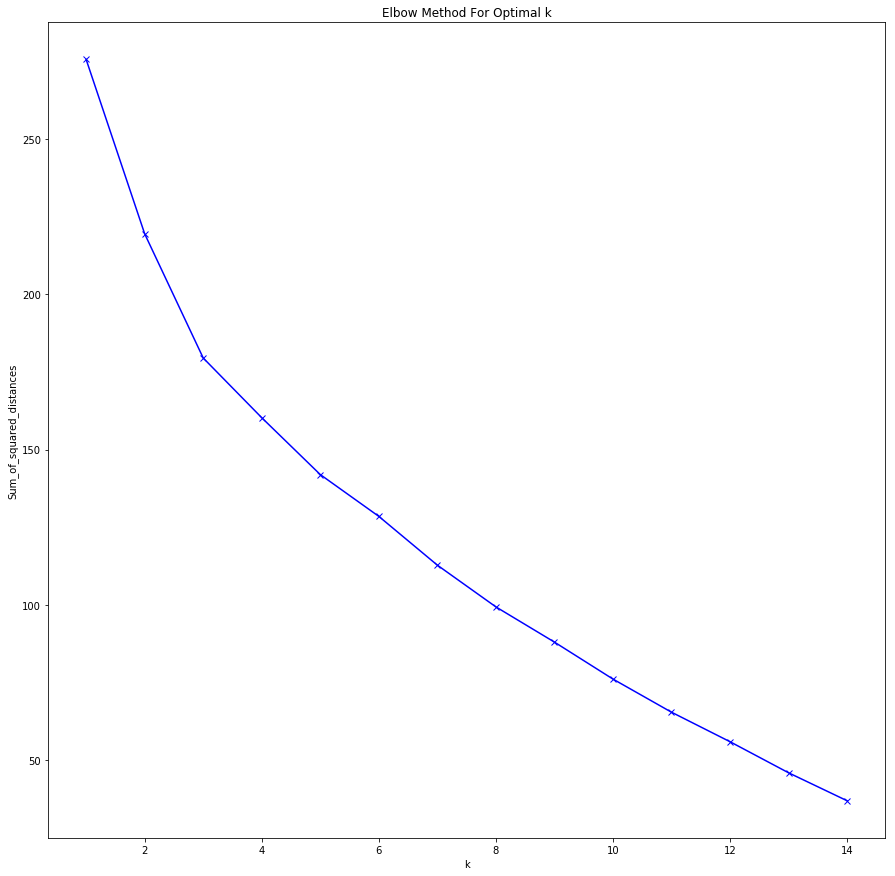

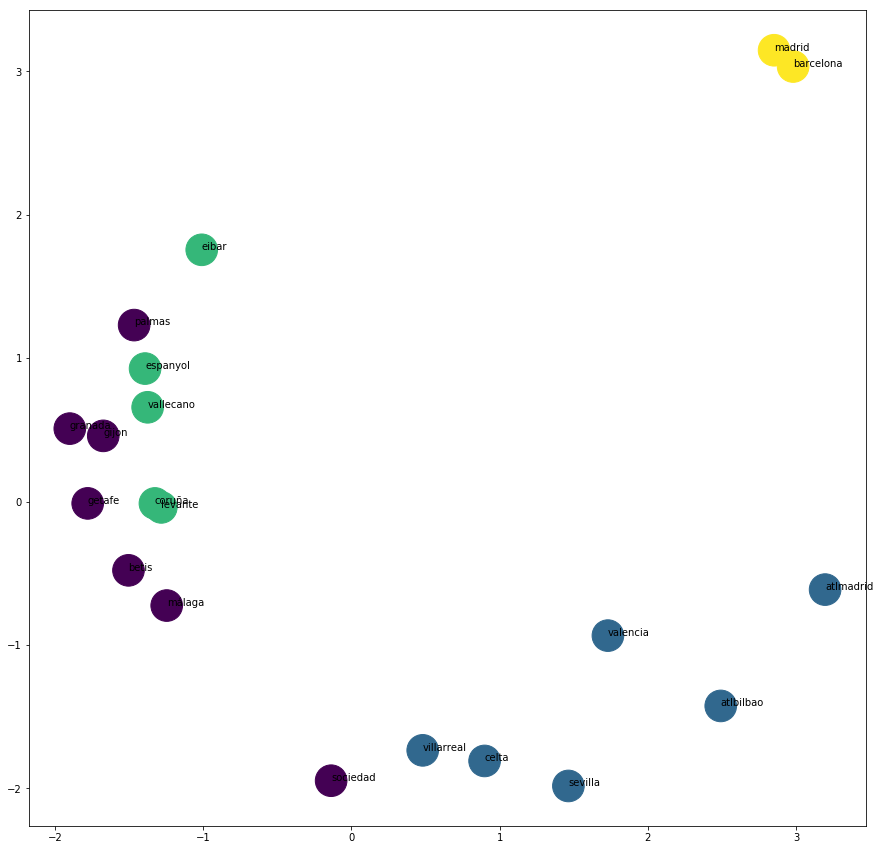

     team_away  cluster_team_away_4
0    atlbilbao                    1
1    atlmadrid                    0
2    barcelona                    0
3        betis                    3
4        celta                    1
5       coruña                    2
6        eibar                    0
7     espanyol                    3
8       getafe                    2
9        gijon                    0
10     granada                    1
11     levante                    2
12      madrid                    0
13      málaga                    1
14      palmas                    1
15     sevilla                    2
16    sociedad                    1
17    valencia                    0
18   vallecano                    2
19  villarreal                    0
1


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

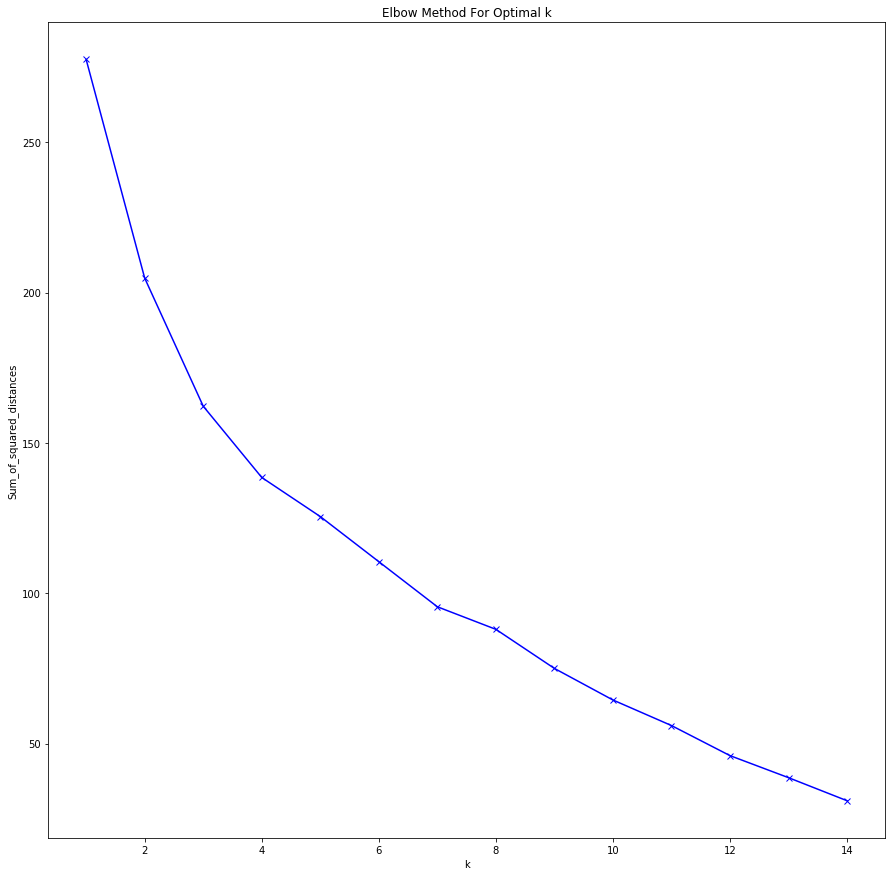

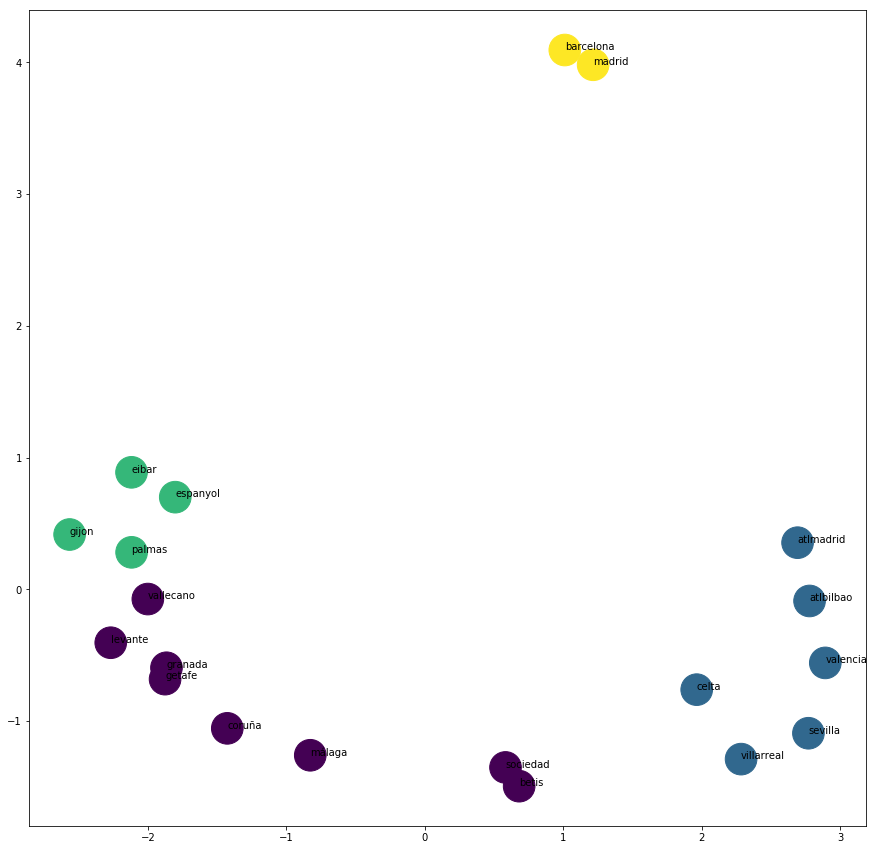

     team_away  cluster_team_away_4
0    atlbilbao                    1
1    atlmadrid                    0
2    barcelona                    0
3        betis                    3
4        celta                    1
5       coruña                    2
6        eibar                    0
7     espanyol                    3
8       getafe                    2
9        gijon                    0
10     granada                    1
11     levante                    2
12      madrid                    0
13      málaga                    1
14      palmas                    1
15     sevilla                    2
16    sociedad                    1
17    valencia                    0
18   vallecano                    2
19  villarreal                    0
     team_away  cluster_team_away_4   team_home  cluster_team_home_4
0    atlbilbao                    1   atlbilbao                    1
1    atlmadrid                    0   atlmadrid                    0
2    barcelona                    0  

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

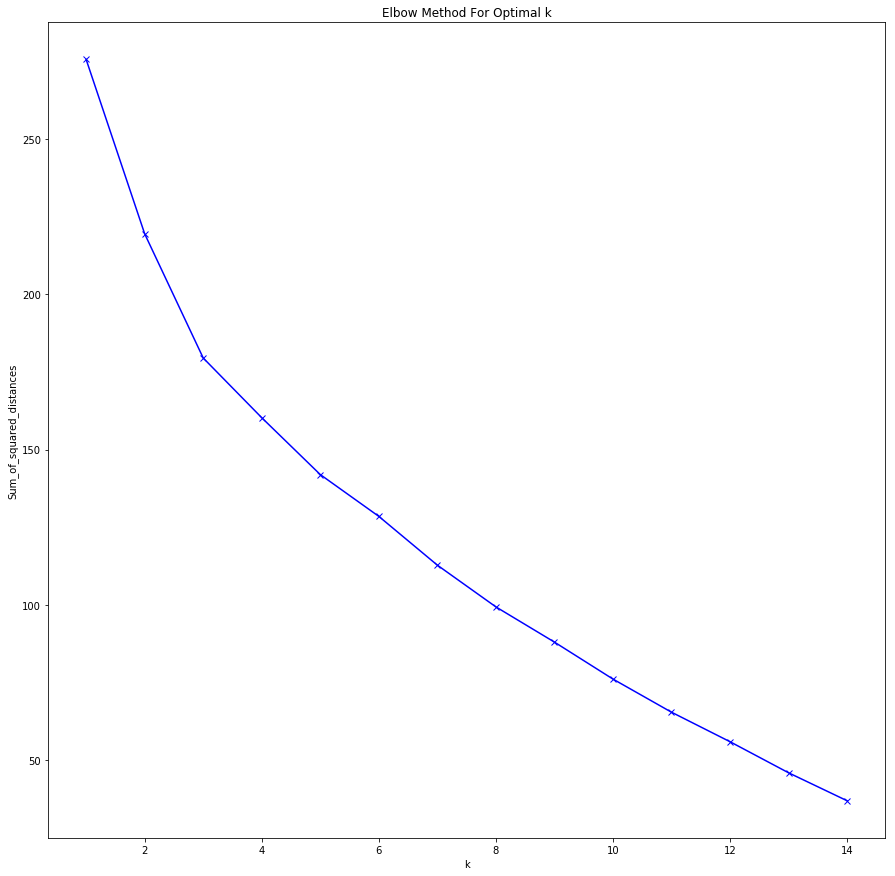

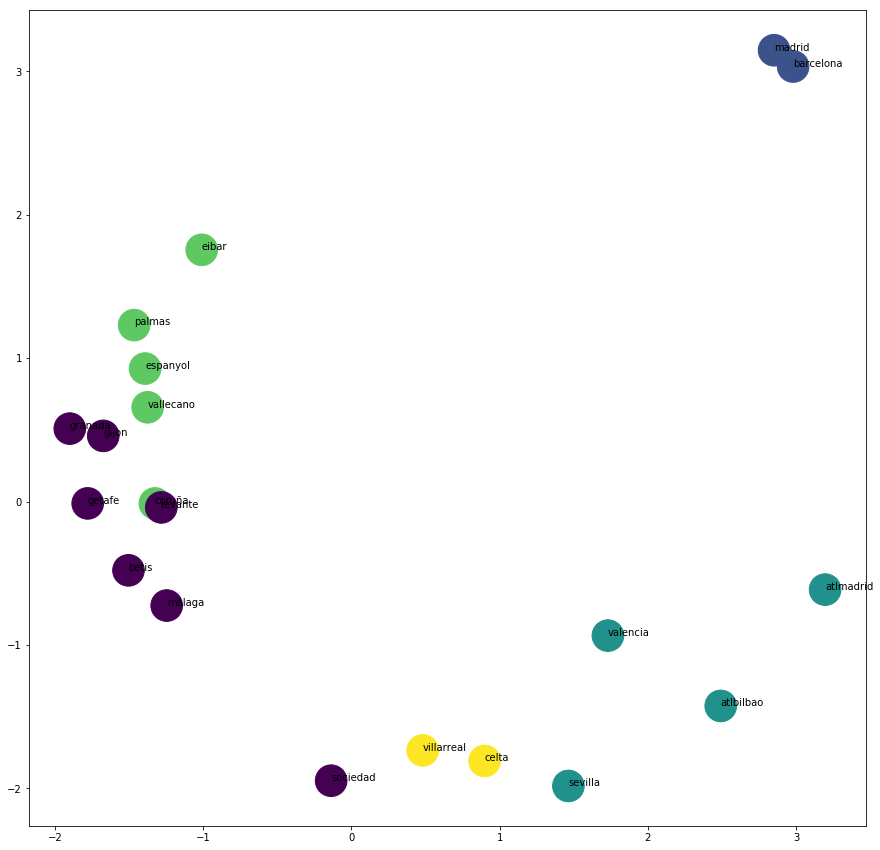

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

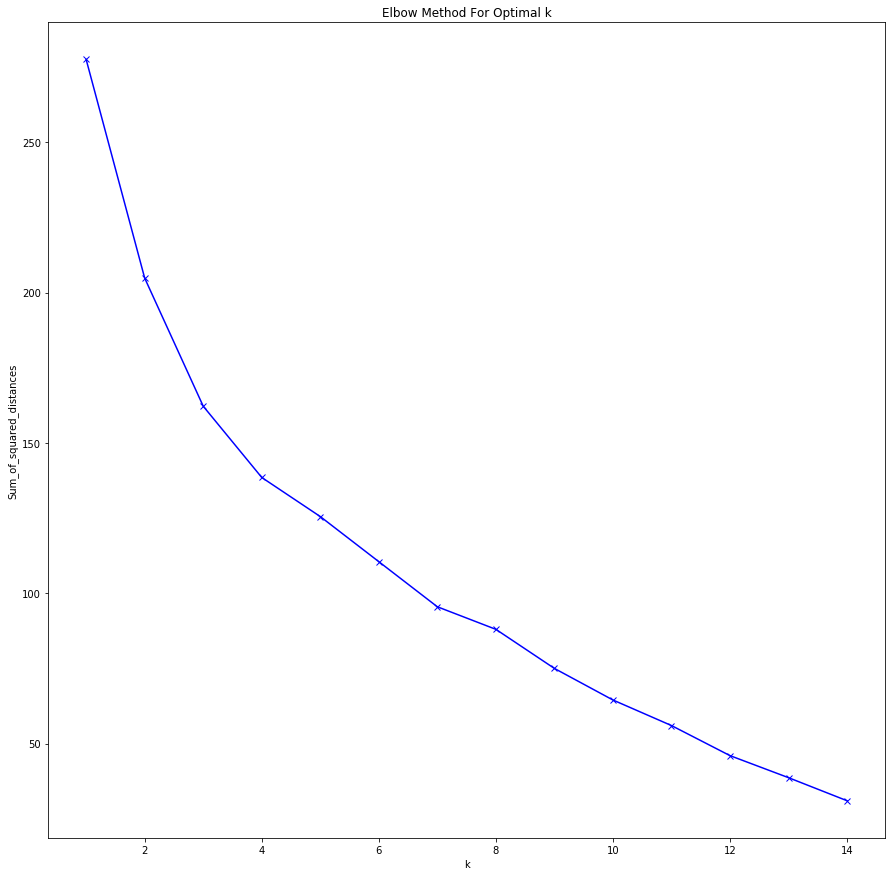

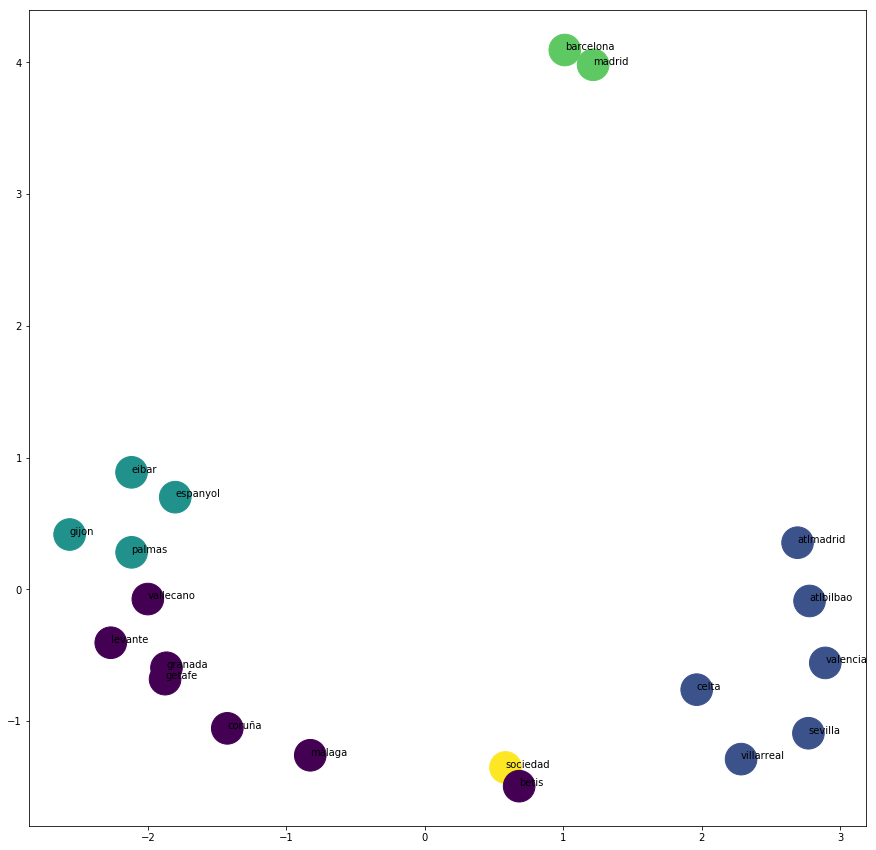

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

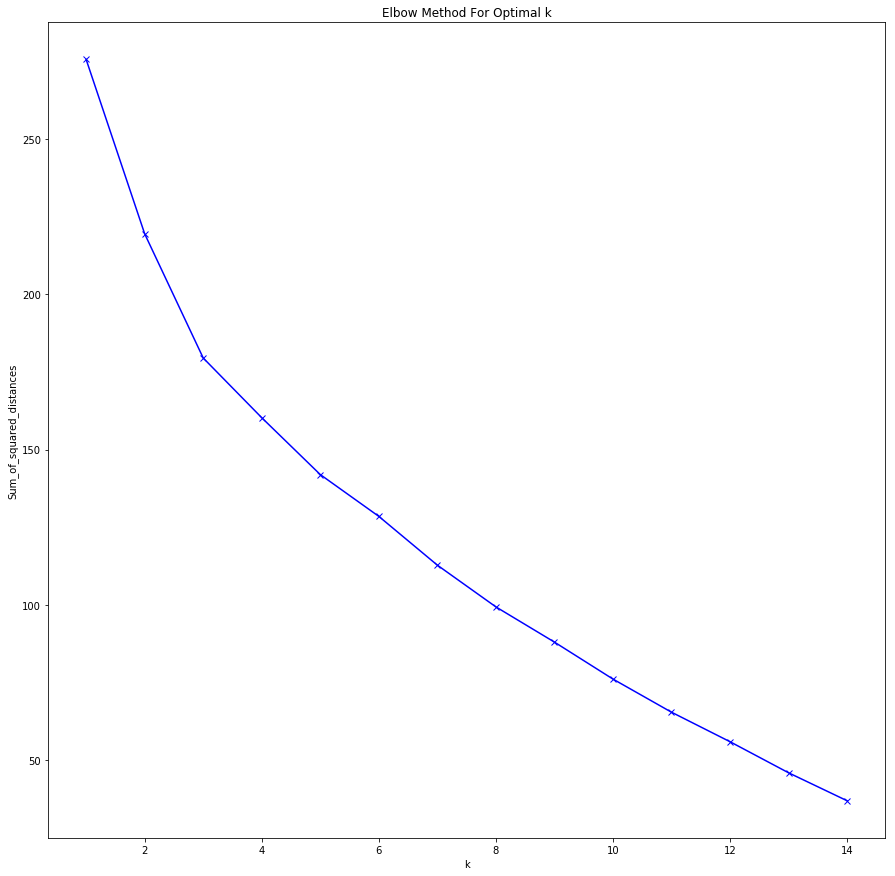

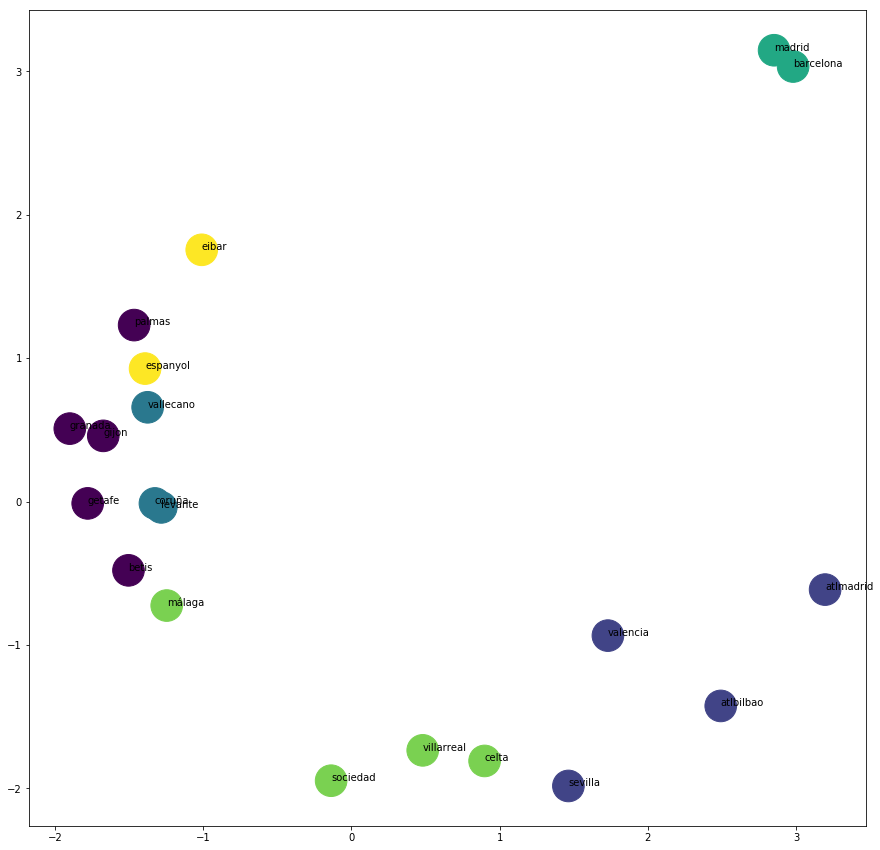

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

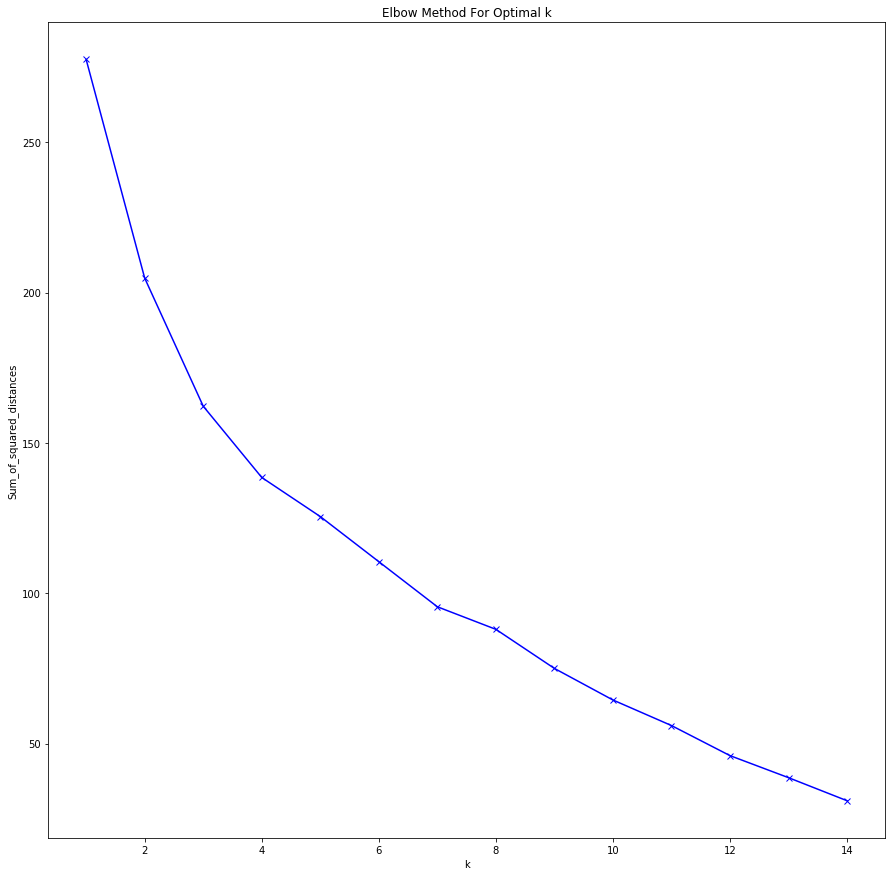

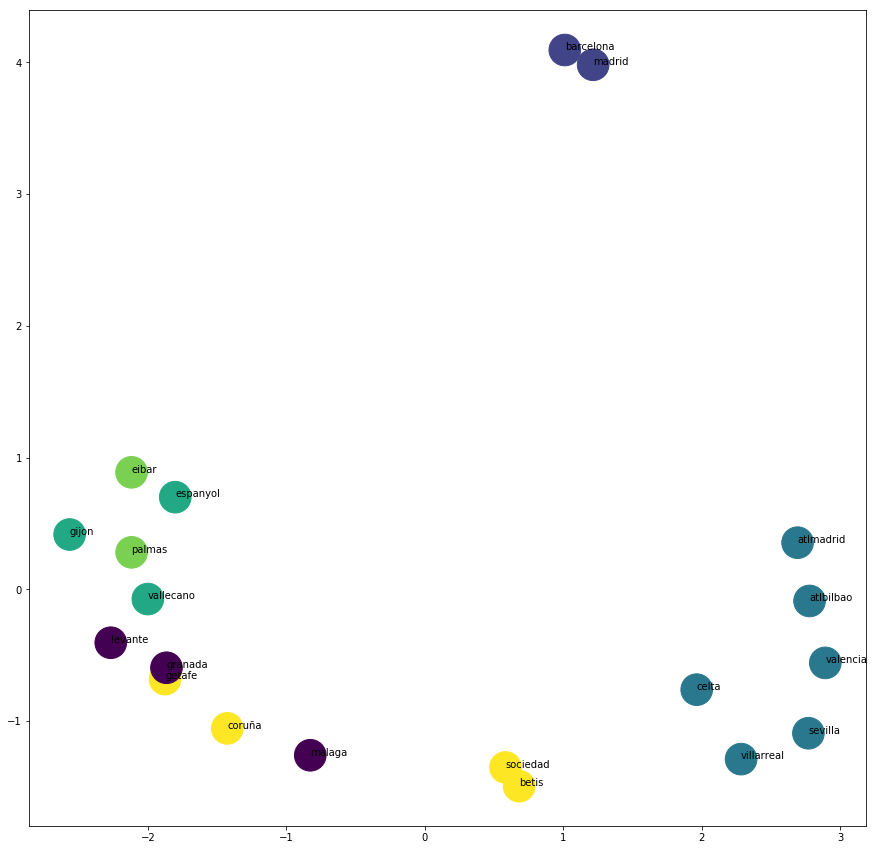

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

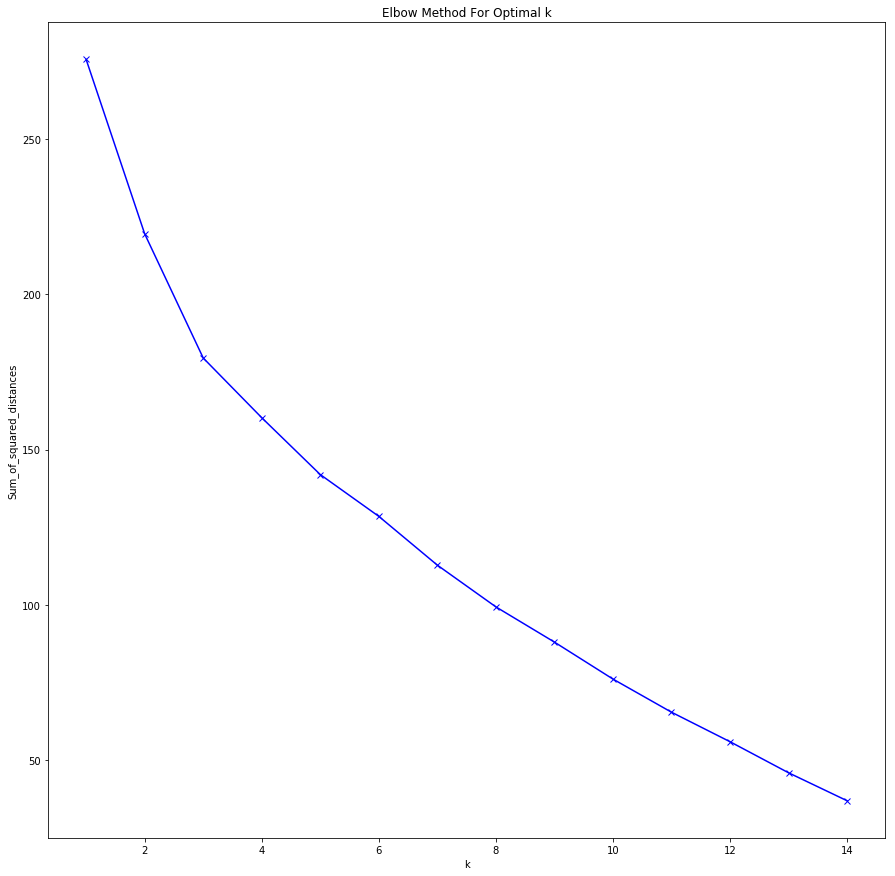

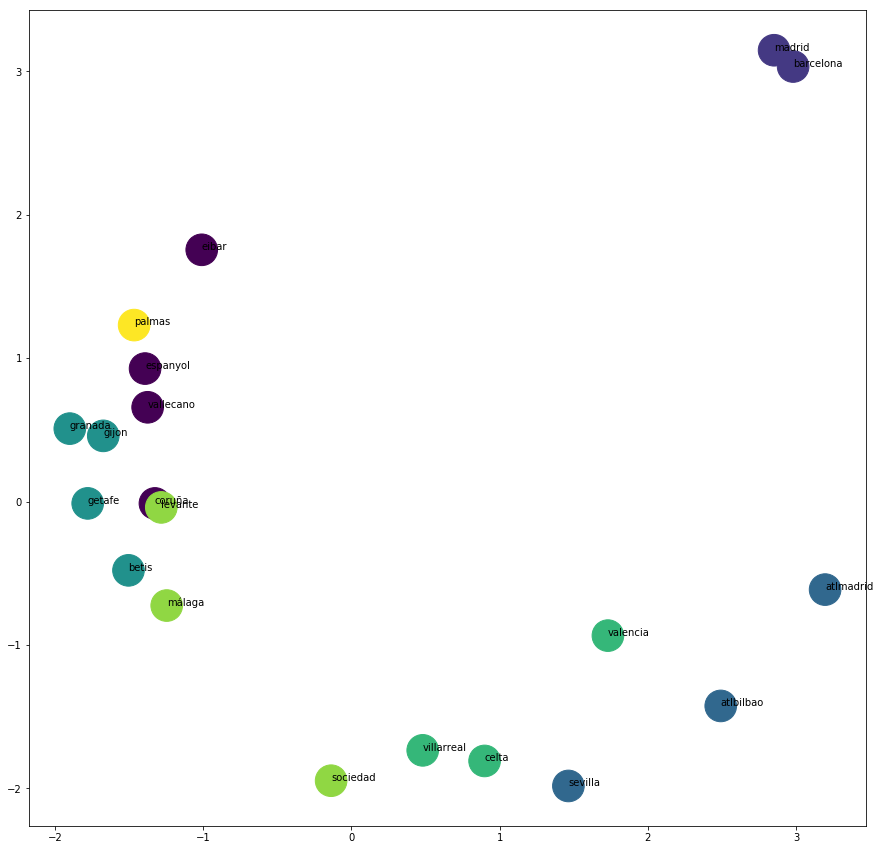

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

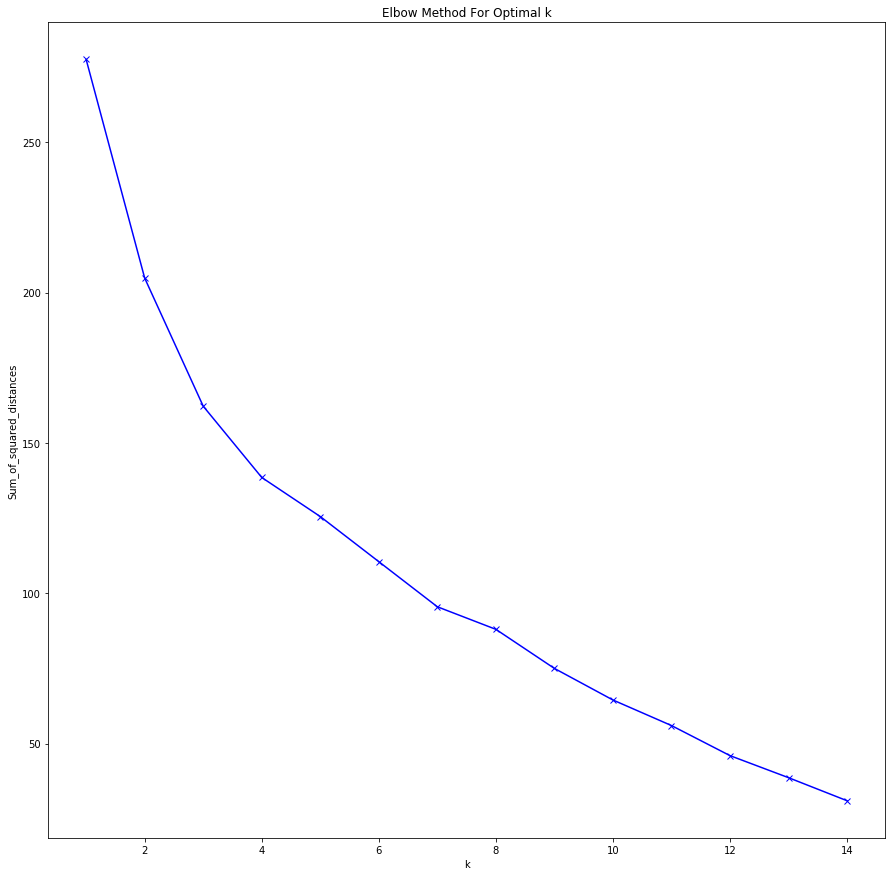

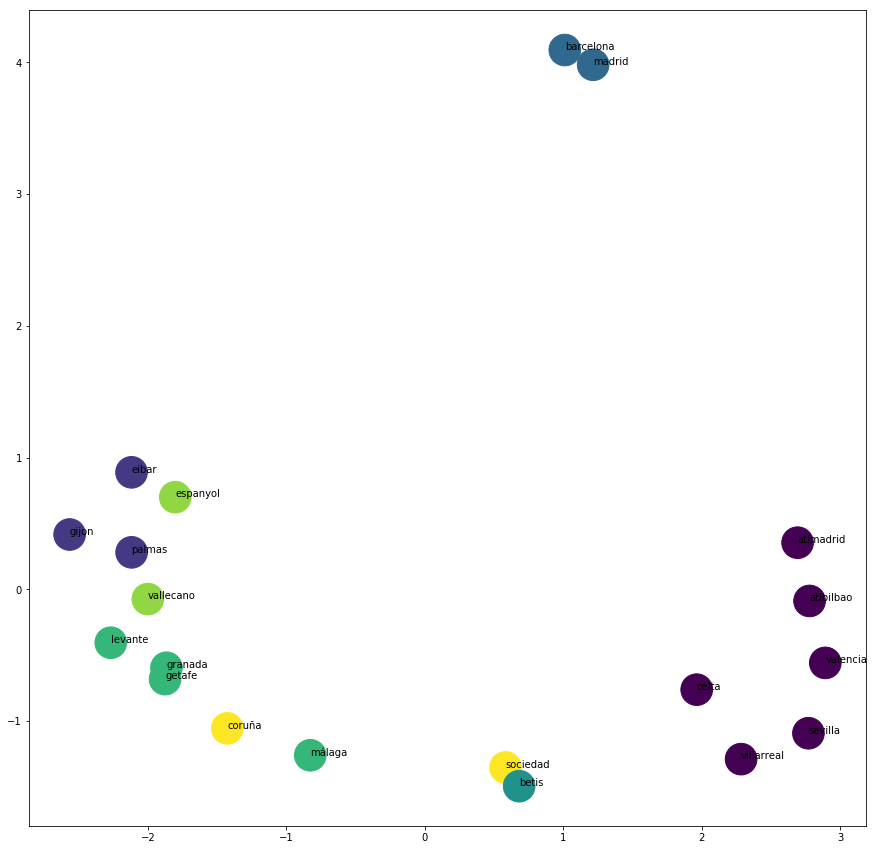

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

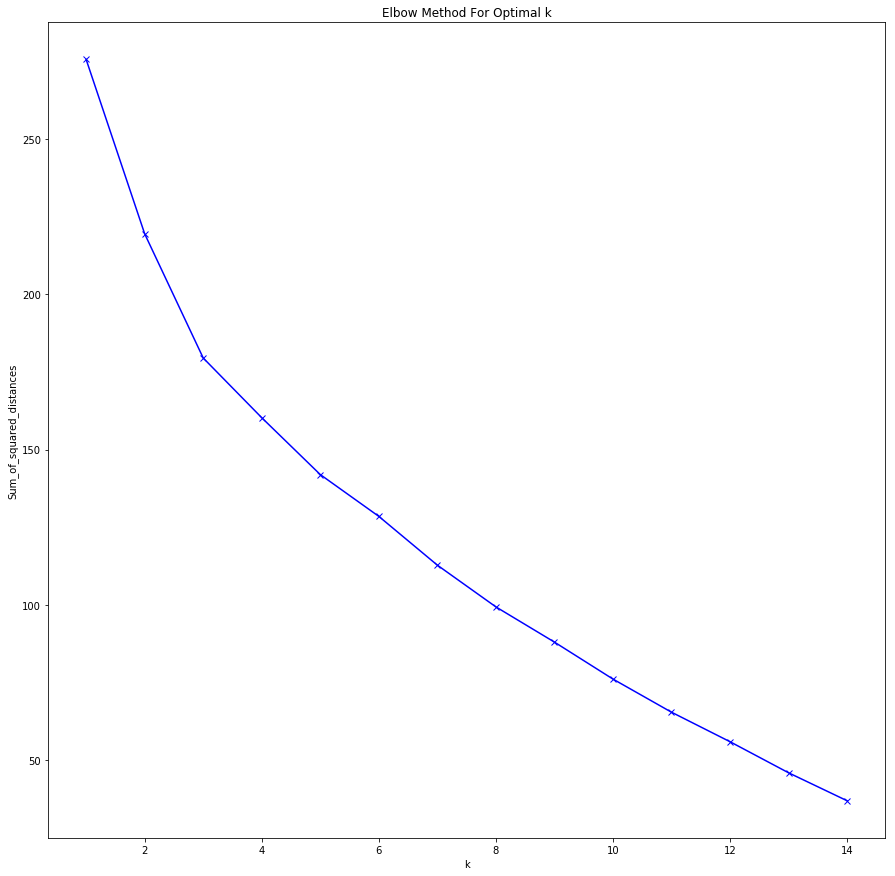

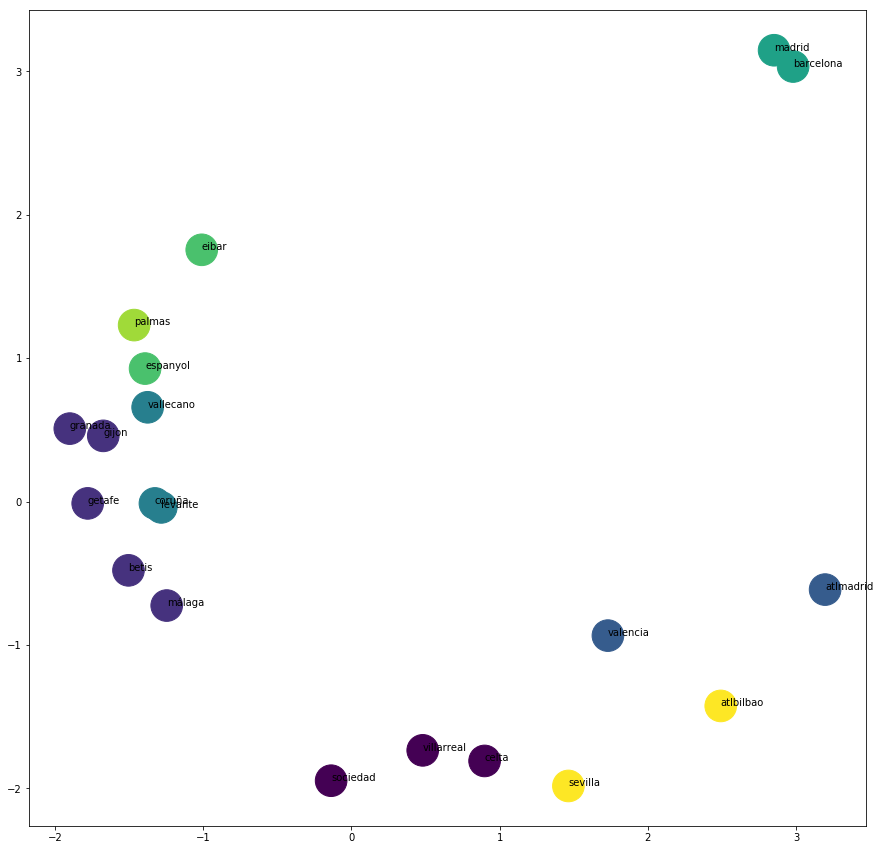

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

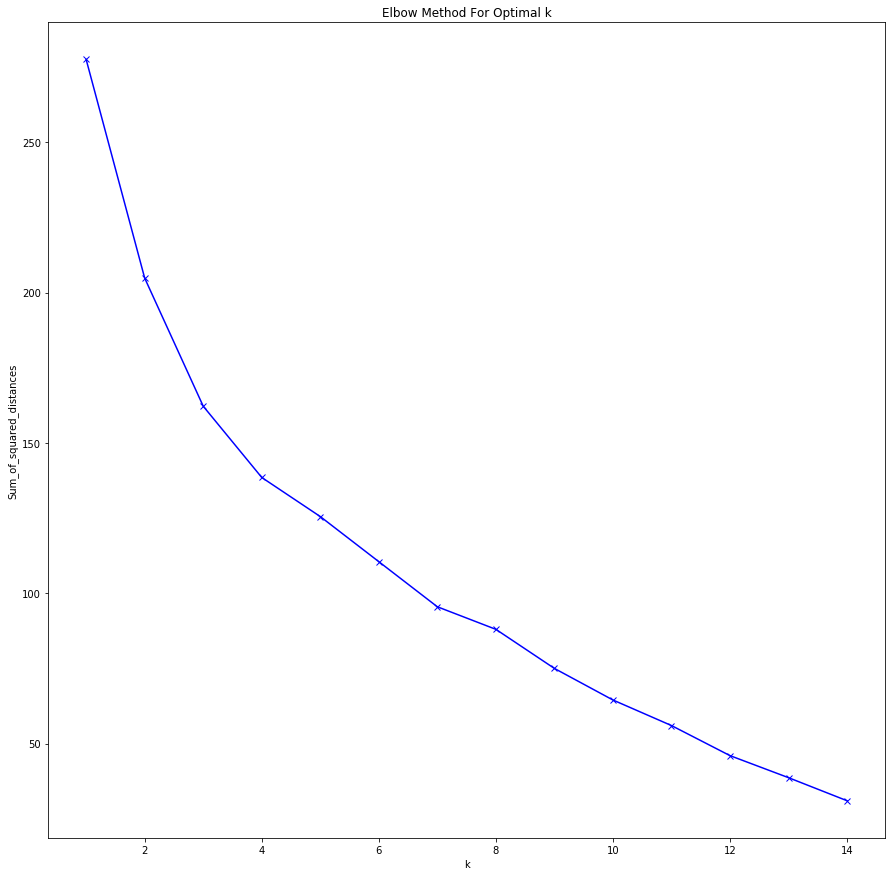

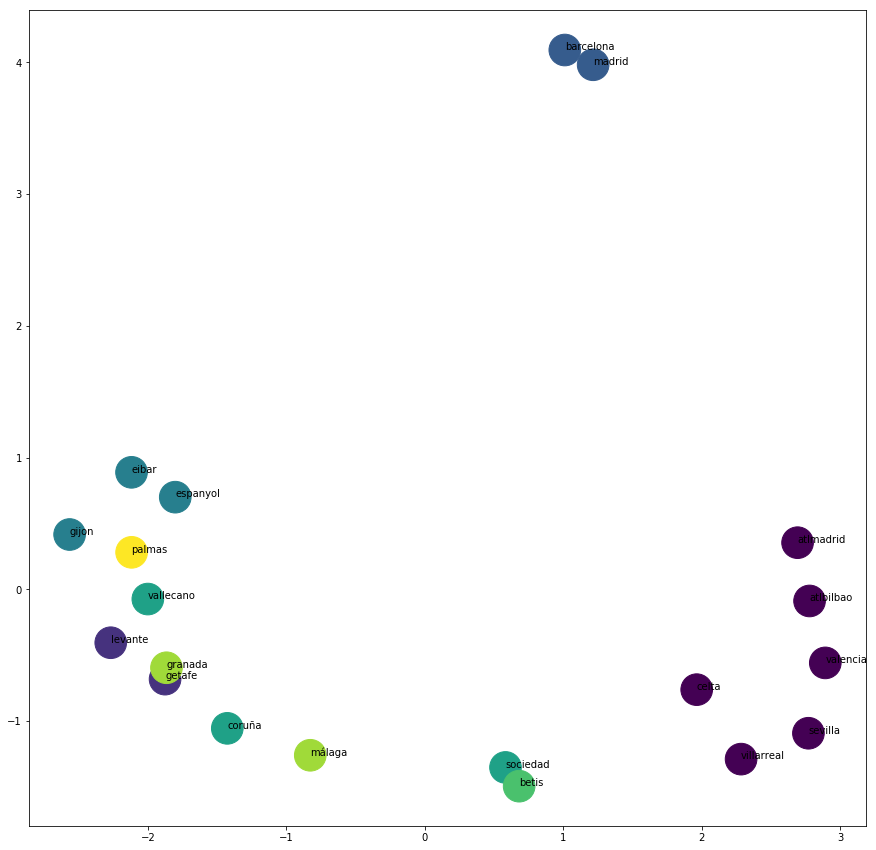

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

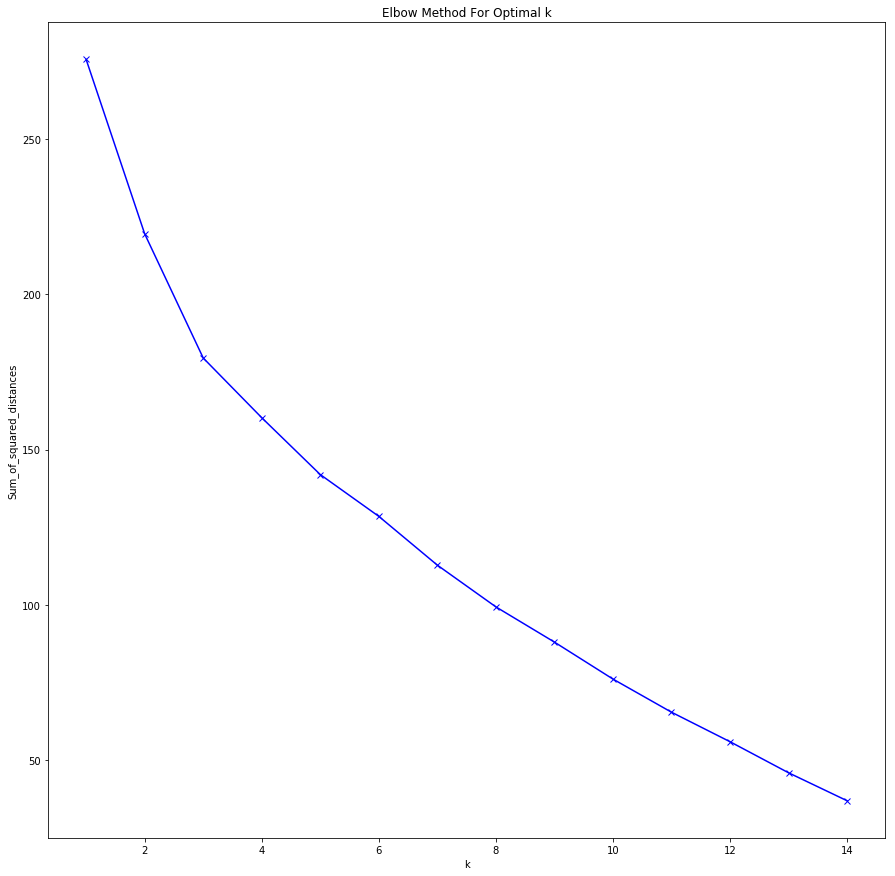

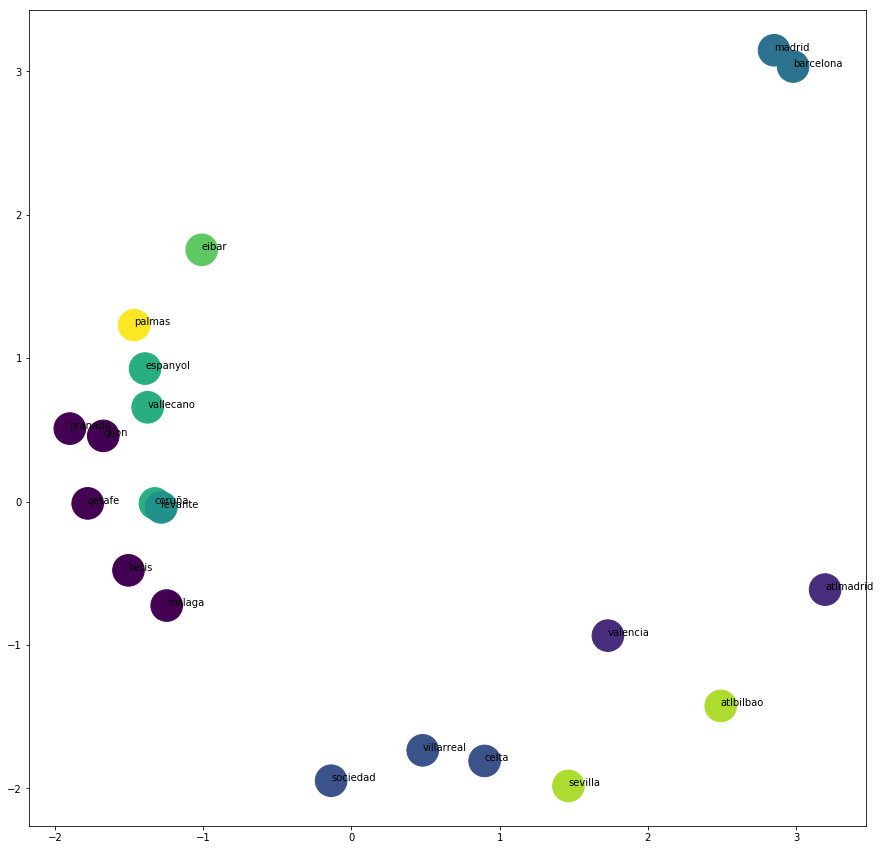

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

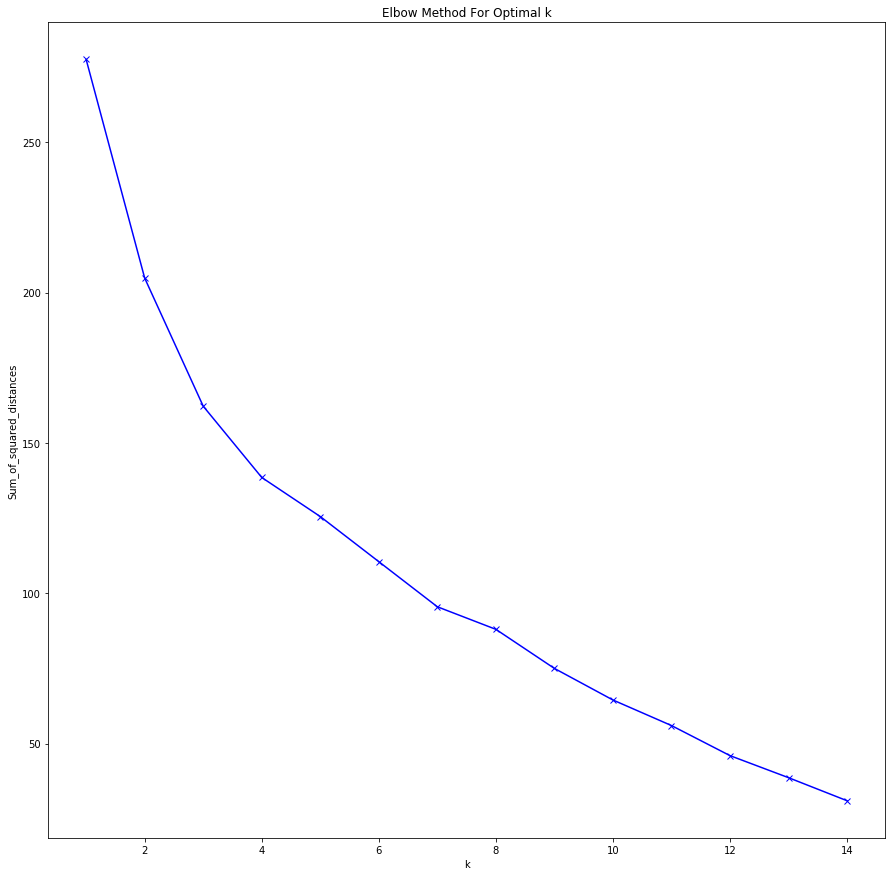

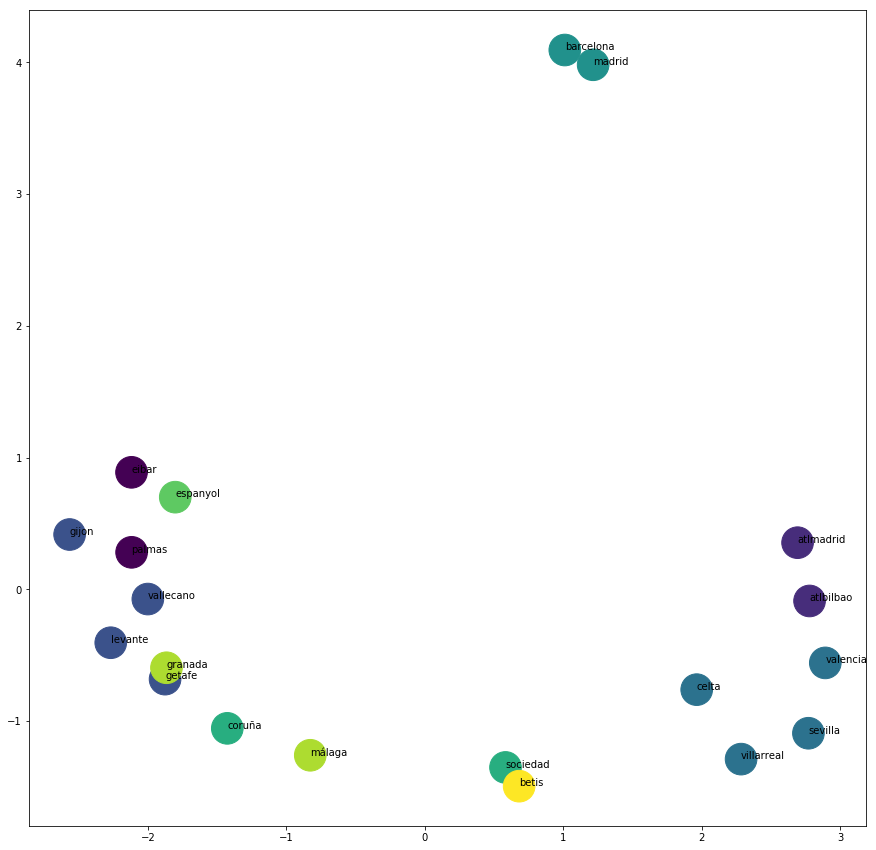

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

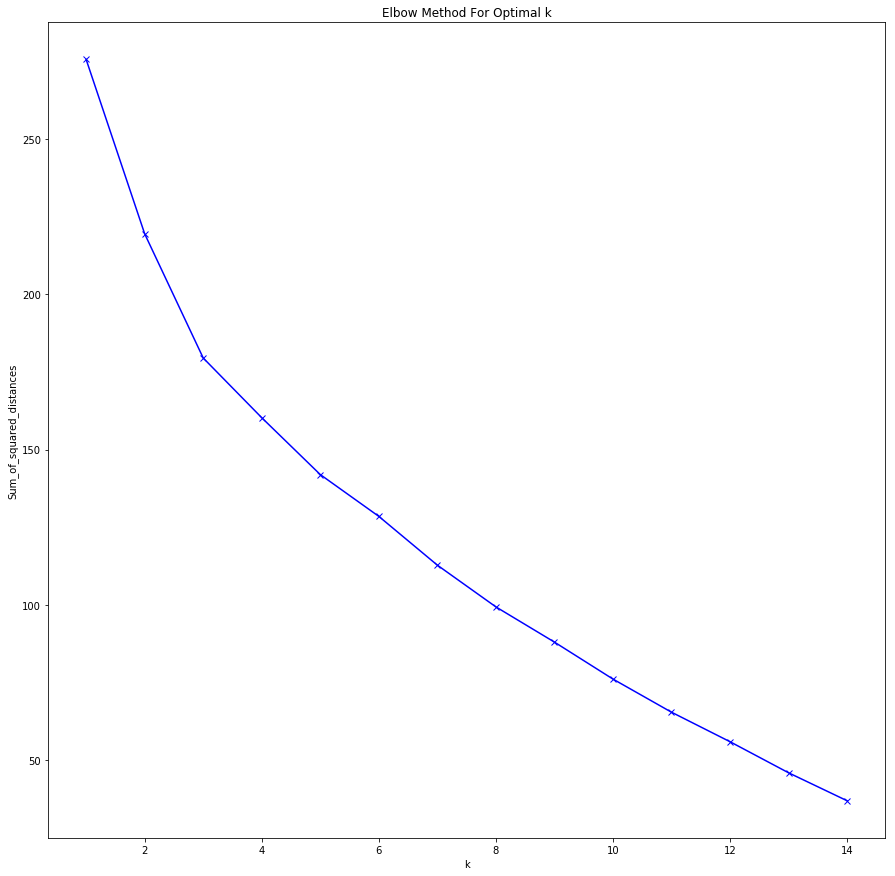

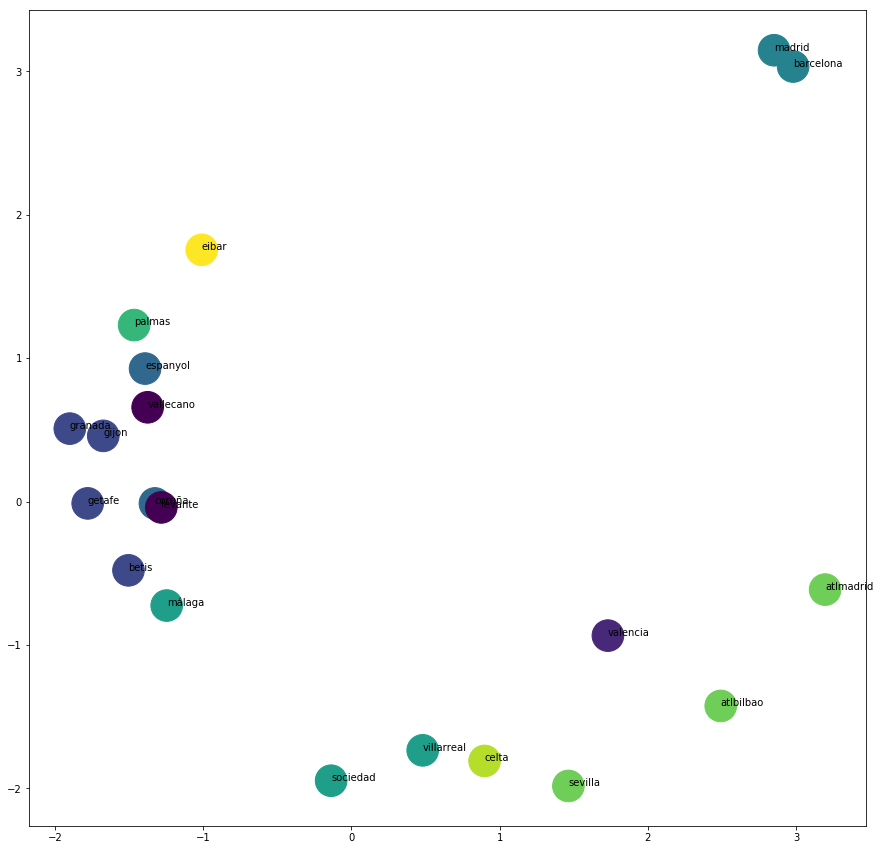

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

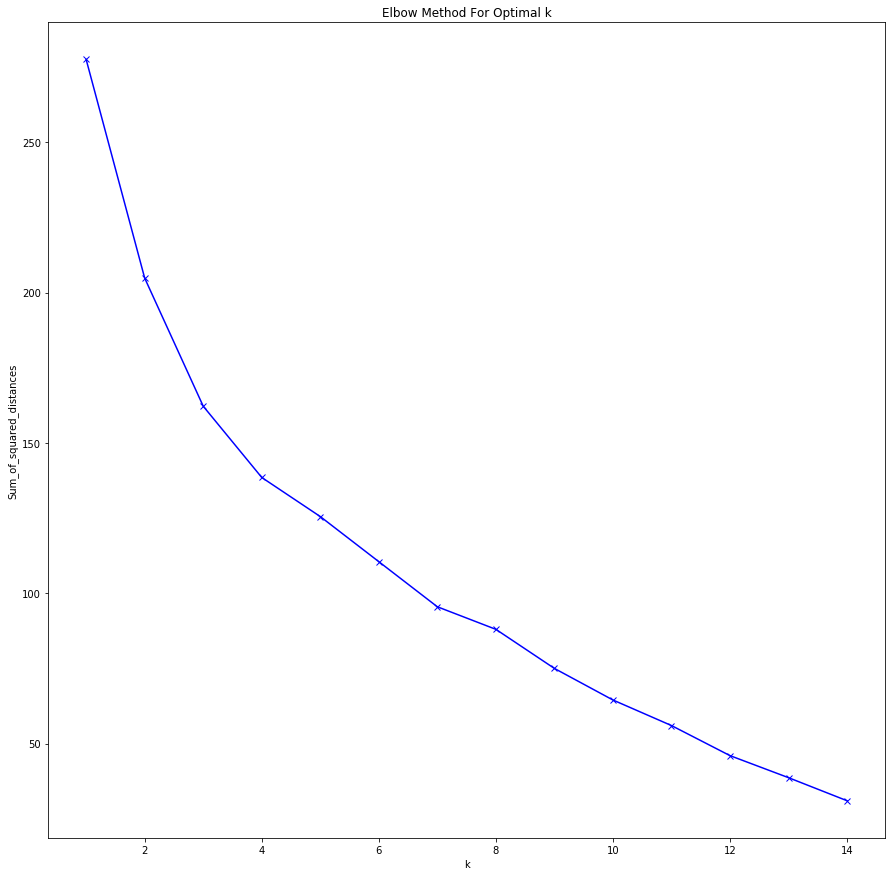

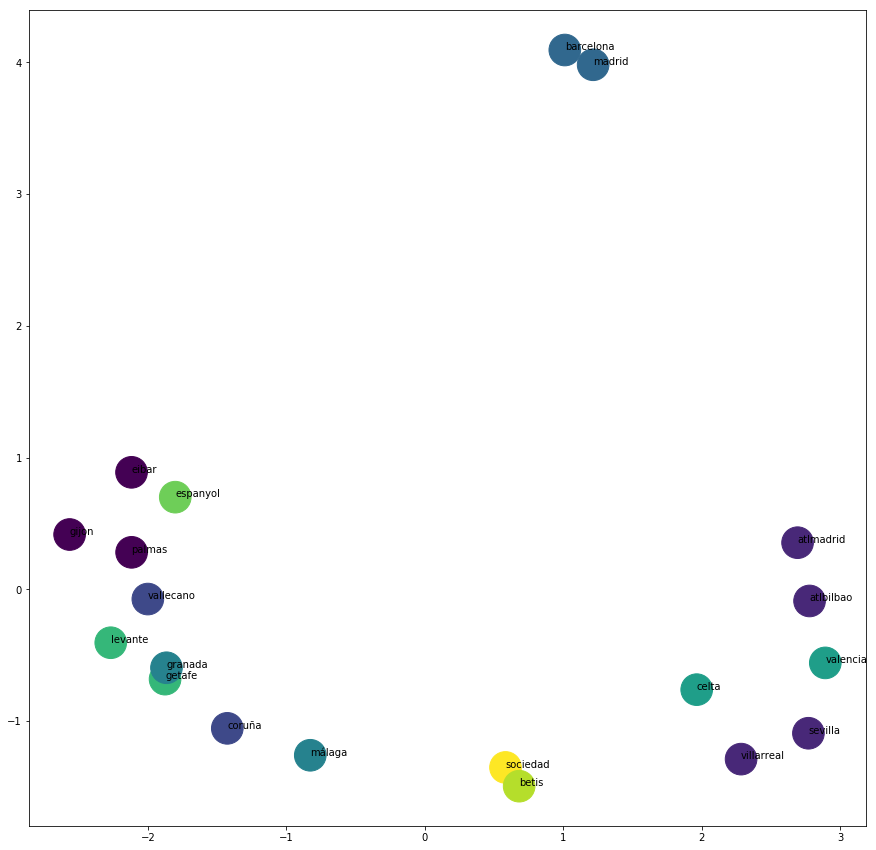

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

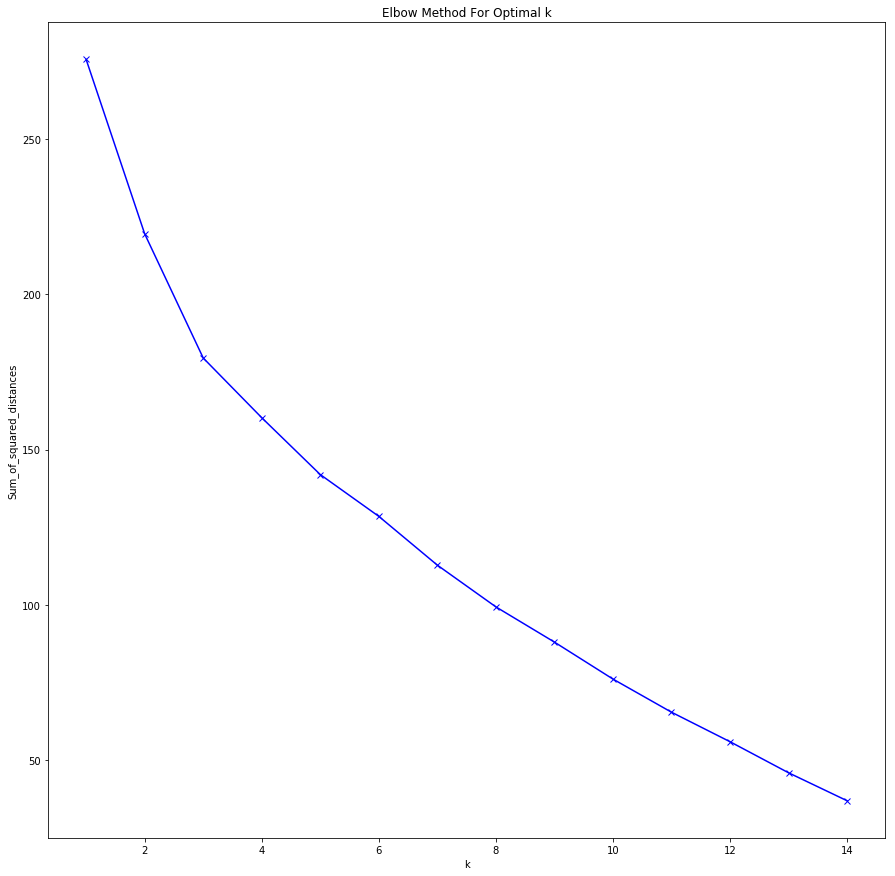

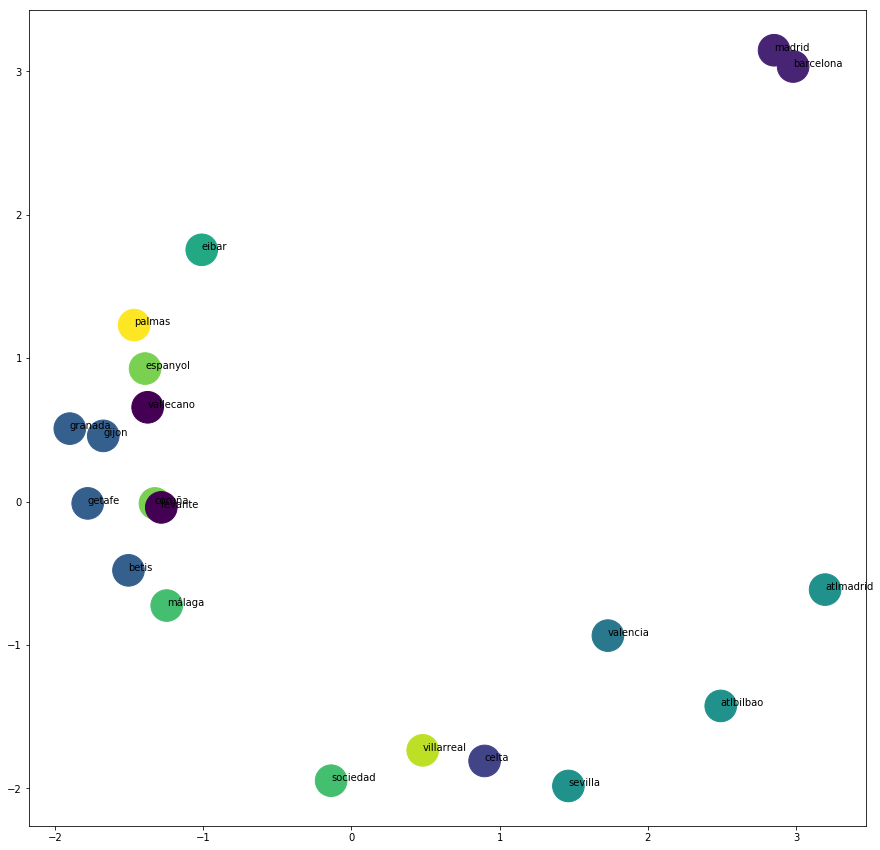

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, valencia to betis
Data columns (total 20 columns):
valencia      20 non-null category
sociedad      20 non-null category
getafe        20 non-null category
madrid        20 non-null category
villarreal    20 non-null category
vallecano     20 non-null category
palmas        20 non-null category
barcelona     20 non-null category
coruña        20 non-null category
málaga        20 non-null category
celta         20 non-null category
levante       20 non-null category
granada       20 non-null category
sevilla       20 non-null category
atlmadrid     20 non-null category
espanyol      20 non-null category
atlbilbao     20 non-null category
gijon         20 non-null category
eibar         20 non-null category
betis         20 non-null category
dtypes: category(20)
memory usage: 5.1+ KB
None
Index(['valencia', 'sociedad', 'getafe', 'madrid', 'villarreal', 'vallecano',
       'palmas', 'barcelona', 'coruña', 'málaga', 'celta', 'levant

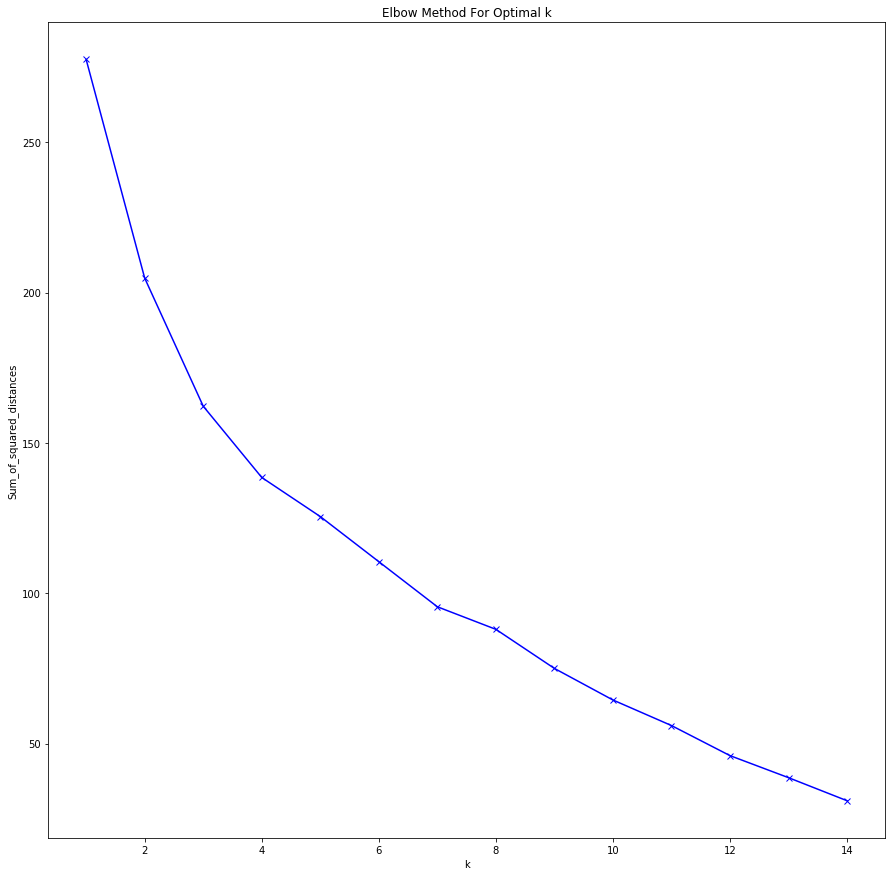

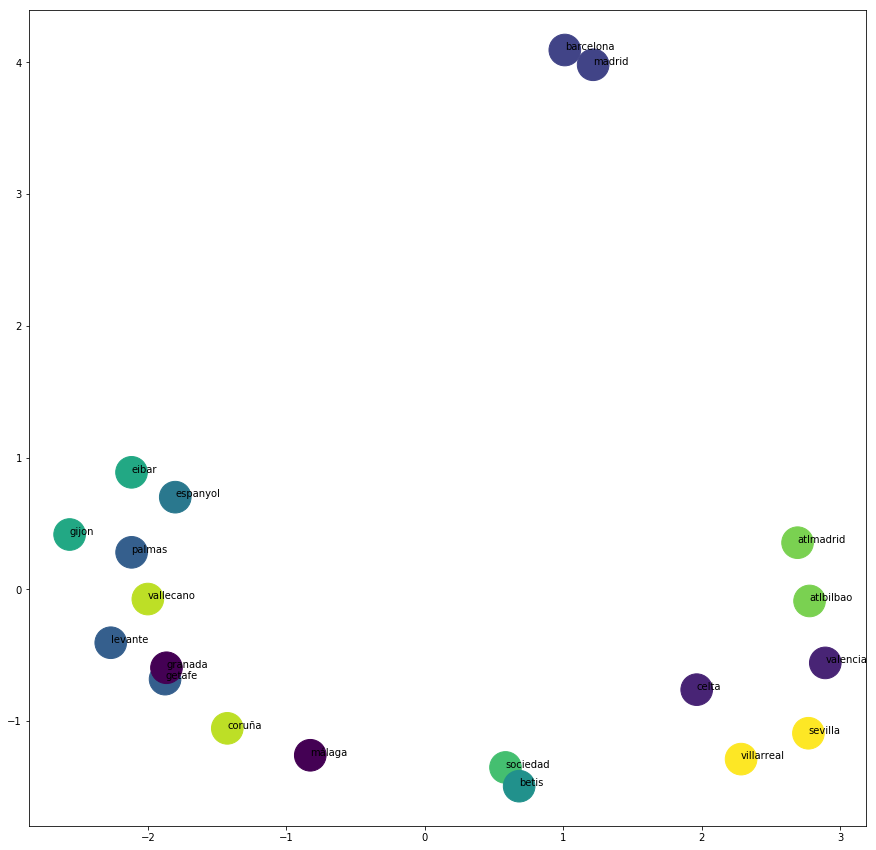

     team_away  cluster_team_away_4   team_home  cluster_team_home_4  \
0    atlbilbao                    1   atlbilbao                    1   
1    atlmadrid                    0   atlmadrid                    0   
2    barcelona                    0   barcelona                    0   
3        betis                    3       betis                    3   
4        celta                    1       celta                    1   
5       coruña                    2      coruña                    0   
6        eibar                    0       eibar                    2   
7     espanyol                    3    espanyol                    3   
8       getafe                    2      getafe                    0   
9        gijon                    0       gijon                    0   
10     granada                    1     granada                    1   
11     levante                    2     levante                    0   
12      madrid                    0      madrid                 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 17 columns):
uid                    380 non-null object
labels                 380 non-null object
home_team_name_id      380 non-null object
away_team_name_id      380 non-null object
date                   380 non-null object
cluster_team_away_4    380 non-null object
cluster_team_home_4    380 non-null object
cluster_team_away_5    380 non-null object
cluster_team_home_5    380 non-null object
cluster_team_away_6    380 non-null object
cluster_team_home_6    380 non-null object
cluster_team_away_7    380 non-null object
cluster_team_home_7    380 non-null object
cluster_team_away_8    380 non-null object
cluster_team_home_8    380 non-null object
cluster_team_away_9    380 non-null object
cluster_team_home_9    380 non-null object
dtypes: object(17)
memory usage: 53.4+ KB
Importing Jupyter notebook from Building_models_function_to_import.ipynb

>>>  CLASSIFIER: lr

---------------------
*** A

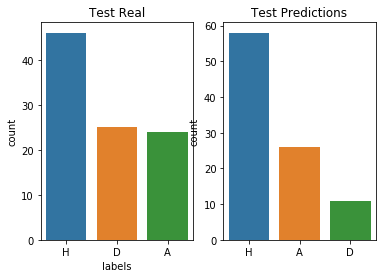

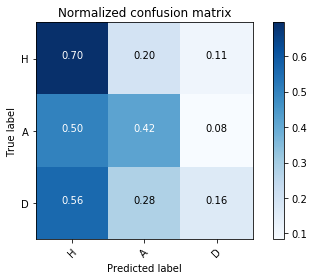

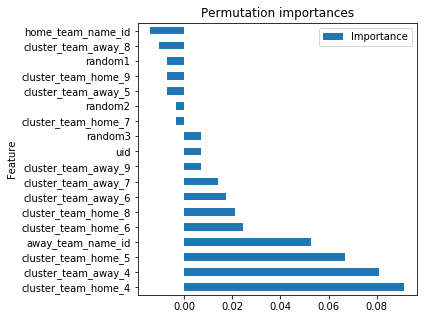

train_accuracy  test_accuracy  f1_score
0         0.57193       0.484211  0.457508


>>>  CLASSIFIER: svc

---------------------
*** ACCURACY ***
---------------------
Accuracy of svc classifier on training set: 0.96
Accuracy of svc classifier on test set: 0.46

---------------------
*** F1 SCORE ***
---------------------
F1 Score of svc classifier on test set: 0.34

---------------------
*** CONFUSION MATRIX ***
---------------------
Normalized confusion matrix


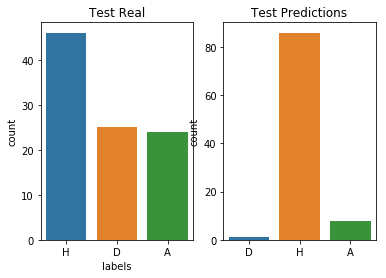

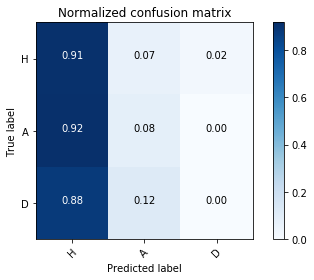

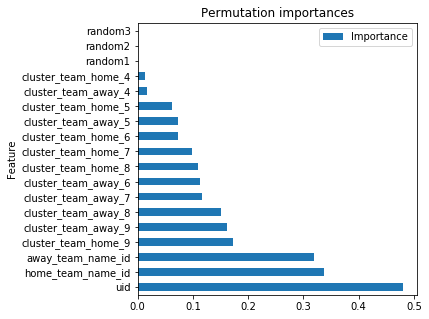

train_accuracy  test_accuracy  f1_score
0        0.964912       0.463158  0.339713


>>>  CLASSIFIER: rf

---------------------
*** ACCURACY ***
---------------------
Accuracy of rf classifier on training set: 0.84
Accuracy of rf classifier on test set: 0.53

---------------------
*** F1 SCORE ***
---------------------
F1 Score of rf classifier on test set: 0.48

---------------------
*** CONFUSION MATRIX ***
---------------------
Normalized confusion matrix


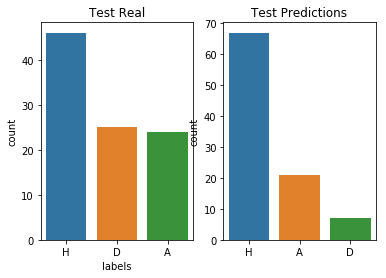

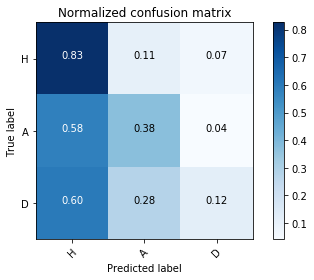

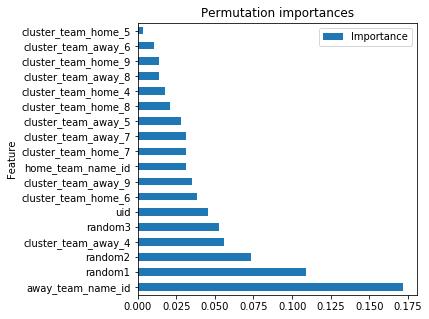

train_accuracy  test_accuracy  f1_score
0        0.835088       0.526316  0.476058

In [8]:
first_clustering = 4
second_clustering = 5

df_cluster = pd.DataFrame()

K = range(4,12)
for second_clustering in K:

    for i in range(2):
        print(i)
        if i == 0:    
            for team in name_teams:
                df_clustering_teams =df_clustering.loc[df_clustering['home_team_name_id']== team,:]


                ## Remove Rows With Missing Values
                df_clustering_teams.dropna(inplace=True)

                #Remove labels and also the columns that we don't want to use as clustering info
                away_teams =df_clustering_teams['away_team_name_id']
                
                dropcol = ['uid','stage','labels','date','id','home_team_name_id','away_team_name_id']
                for col in df_clustering_teams.columns:
                    if col in dropcol:
                        df_clustering_teams = df_clustering_teams.drop(columns= col)


                #Clustering. We use K =5 because we want to distinct between(H+,H,D,A,A+)
                kmeans = KMeans(n_clusters=first_clustering, random_state=111)
                kmeans.fit(df_clustering_teams)


                #Plotting clustering in pca2 dimensions
                pca = PCA(n_components=2).fit(df_clustering_teams)
                pca_2d = pca.transform(df_clustering_teams)

            #     fig, ax = plt.subplots(figsize=(15,15))
            #     fig.suptitle(f'Home Team: {team}', fontsize=16)
            #     ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)
            #     for i, txt in enumerate(away_teams):
            #         ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))


                df_clust = pd.DataFrame(columns=['team_away','cluster_labels'])
                df_clust['team_away']= away_teams
                df_clust['cluster_labels']= kmeans.labels_

                #Filling our df with the values we want to use for clustering. In this particular case this values come from a previous clustering.
                for away_team in away_teams:
                    df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()



            #Fill NaN values due to teams playing to themselves, or due to first match day.
            df =df.fillna('unknown')

            #We should now transpose the matrix to have as a columns the "performance calculated" of the team in the row playing away against the team in the column playing at home.
            dfT= df.T

            dfT =dfT.astype('category')

            print(dfT.info())

            dfT = convert_to(dfT,'onehot', all_categorical = True,columns = 'None')

            dfT.info()  

            #Now we make the clustering for those rows. This clustering wants to cluster teams that have same caracteristics playing away.
            name_teams = set(dfT.index)



            Sum_of_squared_distances = []
            K = range(1,15)
            for k in K:
                km = KMeans(n_clusters=k,random_state=111)
                km = km.fit(dfT)
                Sum_of_squared_distances.append(km.inertia_)

            fig, ax = plt.subplots(figsize=(15,15))    
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('k')
            plt.ylabel('Sum_of_squared_distances')
            plt.title('Elbow Method For Optimal k')
            plt.show()


            kmeans = KMeans(n_clusters=second_clustering, random_state=111)
            kmeans.fit(dfT)

            pca = PCA(n_components=2).fit(dfT)
            pca_2d = pca.transform(dfT)

            fig, ax = plt.subplots(figsize=(15,15))
            ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)


            for i, txt in enumerate(name_teams):
                ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))

            plt.show()


            
            df_cluster['team_away']= dfT.index.sort_values()
            df_cluster[f'cluster_team_away_{second_clustering}']= kmeans.labels_ 
            print(df_cluster)


        elif i ==1:
            for team in name_teams:
                df_clustering_teams =df_clustering.loc[df_clustering['away_team_name_id']== team,:]


                ## Remove Rows With Missing Values
                df_clustering_teams.dropna(inplace=True)

                #Remove labels and also the columns that we don't want to use as clustering info
                away_teams =df_clustering_teams['home_team_name_id']
                
                dropcol = ['uid','stage','labels','date','id','home_team_name_id','away_team_name_id']
                for col in df_clustering_teams.columns:
                    if col in dropcol:
                        df_clustering_teams = df_clustering_teams.drop(columns= col)


                

                #Clustering. We use K =5 because we want to distinct between(H+,H,D,A,A+)
                kmeans = KMeans(n_clusters=first_clustering, random_state=111)
                kmeans.fit(df_clustering_teams)


                #Plotting clustering in pca2 dimensions
                pca = PCA(n_components=2).fit(df_clustering_teams)
                pca_2d = pca.transform(df_clustering_teams)

            #     fig, ax = plt.subplots(figsize=(15,15))
            #     fig.suptitle(f'Home Team: {team}', fontsize=16)
            #     ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)
            #     for i, txt in enumerate(away_teams):
            #         ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))


                df_clust = pd.DataFrame(columns=['team_away','cluster_labels'])
                df_clust['team_away']= away_teams
                df_clust['cluster_labels']= kmeans.labels_

                #Filling our df with the values we want to use for clustering. In this particular case this values come from a previous clustering.
                for away_team in away_teams:
                    df.loc[team,away_team] = df_clust.loc[df_clust['team_away']== away_team,'cluster_labels'].item()



            #Fill NaN values due to teams playing to themselves, or due to first match day.
            df =df.fillna('unknown')

            #We should now transpose the matrix to have as a columns the "performance calculated" of the team in the row playing away against the team in the column playing at home.
            dfT= df.T

            dfT =dfT.astype('category')

            print(dfT.info())

            dfT = convert_to(dfT,'onehot', all_categorical = True,columns = 'None')

            dfT.info()  

            #Now we make the clustering for those rows. This clustering wants to cluster teams that have same caracteristics playing away.
            name_teams = set(dfT.index)



            Sum_of_squared_distances = []
            K = range(1,15)
            for k in K:
                km = KMeans(n_clusters=k,random_state=111)
                km = km.fit(dfT)
                Sum_of_squared_distances.append(km.inertia_)

            fig, ax = plt.subplots(figsize=(15,15))    
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('k')
            plt.ylabel('Sum_of_squared_distances')
            plt.title('Elbow Method For Optimal k')
            plt.show()


            kmeans = KMeans(n_clusters=second_clustering, random_state=111)
            kmeans.fit(dfT)

            pca = PCA(n_components=2).fit(dfT)
            pca_2d = pca.transform(dfT)

            fig, ax = plt.subplots(figsize=(15,15))
            ax.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_, s=1000)

            for i, txt in enumerate(name_teams):
                ax.annotate(txt, (pca_2d[i, 0], pca_2d[i, 1]))


            plt.show()

            print(df_cluster)

            df_cluster['team_home']= dfT.index.sort_values()
            df_cluster[f'cluster_team_home_{second_clustering}']= kmeans.labels_ 
            print(df_cluster)


df_cluster

df_clustering['uid']= df_clustering['home_team_name_id']+df_clustering['away_team_name_id']

# Let's see if this cluster information alone can give us any useful information


df_clustering.head()
df_testing_clustering = df_clustering[['uid','labels','home_team_name_id','away_team_name_id','date']]

def include_cluster_away(team_away,df_cluster, cluster_team_away):
    clus_away = df_cluster.loc[df_cluster['team_away']==team_away, cluster_team_away].item()
    return clus_away



def include_cluster_home(team_home,df_cluster,cluster_team_home):
    clus_home = df_cluster.loc[df_cluster['team_home']==team_home, cluster_team_home].item()
    return clus_home

#df_testing_clustering['cluster_team_away'] = df_testing_clustering.apply(lambda x: include_cluster_away(x['away_team_name_id'], df_cluster), axis =1 )


#df_testing_clustering['cluster_team_home'] = df_testing_clustering.apply(lambda x: include_cluster_home(x['home_team_name_id'], df_cluster), axis =1 )


#df_testing_clustering['cluster_team_home']= df_testing_clustering['cluster_team_home'].astype(str)
#df_testing_clustering['cluster_team_away'] = df_testing_clustering['cluster_team_away'].astype(str)

K = range(4,10)
for second_clustering in K:
    df_testing_clustering[f'cluster_team_away_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_away(x['away_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)


    df_testing_clustering[f'cluster_team_home_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_home(x['home_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)


df_testing_clustering.info()

df_testing_clustering = df_testing_clustering.drop(columns= ['date'])

import nbimporter
import Building_models_function_to_import



categoric_types = df_testing_clustering.select_dtypes(include=['category','object']).columns.tolist()
categoric_types.remove('labels')
if categoric_types == []:
    categoric_types = [False]


import warnings
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    result, fi, df_wrong_predictions = Building_models_function_to_import.classifiers_performances(df_testing_clustering, scaler= False, onehot=[False], labelling= categoric_types, feature_importance = True)


In [9]:
df_testing_clustering.head()

uid labels home_team_name_id away_team_name_id  \
0        levantecelta      A           levante             celta   
1     atlmadridpalmas      H         atlmadrid            palmas   
2       málagasevilla      D            málaga           sevilla   
3  atlbilbaobarcelona      A         atlbilbao         barcelona   
4        granadaeibar      A           granada             eibar   

  cluster_team_away_4 cluster_team_home_4 cluster_team_away_5  \
0                   1                   2                   4   
1                   1                   0                   2   
2                   2                   1                   3   
3                   0                   1                   0   
4                   0                   1                   3   

  cluster_team_home_5 cluster_team_away_6 cluster_team_home_6  \
0                   0                   4                   2   
1                   0                   1                   4   
2                   2                   5                   1   
3                   2                   0                   1   
4                   4                   0                   4   

  cluster_team_away_7 cluster_team_home_7 cluster_team_away_8  \
0                   4                   5                   0   
1                   2                   5                   2   
2                   0                   2                   5   
3                   3                   4                   1   
4                   6                   4                   6   

  cluster_team_home_8 cluster_team_away_9 cluster_team_home_9  
0                   3                   2                   4  
1                   0                   1                   2  
2                   7                   5                   7  
3                   2                   0                   1  
4                   0                   8                   2

# Let's see if this cluster information alone can give us any useful information

In [10]:
df_testing_clustering
df_clustering.head()
if 'date' in df_clustering.columns:
    df_testing_clustering = df_clustering[['uid','labels','home_team_name_id','away_team_name_id','date']]
else:
    df_testing_clustering = df_clustering[['uid','labels','home_team_name_id','away_team_name_id']]


def include_cluster_away(team_away,df_cluster, cluster_team_away):
    clus_away = df_cluster.loc[df_cluster['team_away']==team_away, cluster_team_away].item()
    return clus_away
def include_cluster_away(team_away,df_cluster, cluster_team_away):
    clus_away = df_cluster.loc[df_cluster['team_away']==team_away, cluster_team_away].item()
    return clus_away
def include_cluster_home(team_home,df_cluster,cluster_team_home):
    clus_home = df_cluster.loc[df_cluster['team_home']==team_home, cluster_team_home].item()
    return clus_home
def include_cluster_home(team_home,df_cluster,cluster_team_home):
    clus_home = df_cluster.loc[df_cluster['team_home']==team_home, cluster_team_home].item()
    return clus_home


K = range(4,10)
for second_clustering in K:
    df_testing_clustering[f'cluster_team_away_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_away(x['away_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)


    df_testing_clustering[f'cluster_team_home_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_home(x['home_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)

K = range(4,10)
for second_clustering in K:
    df_testing_clustering[f'cluster_team_away_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_away(x['away_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)

    df_testing_clustering[f'cluster_team_home_{second_clustering}'] = df_testing_clustering.apply(lambda x: include_cluster_home(x['home_team_name_id'], df_cluster,f'cluster_team_away_{second_clustering}'), axis =1 ).astype(str)


df_testing_clustering.info()

if 'date' in df_clustering.columns:
    df_testing_clustering = df_testing_clustering.drop(columns= ['date'])




/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 17 columns):
uid                    380 non-null object
labels                 380 non-null object
home_team_name_id      380 non-null object
away_team_name_id      380 non-null object
date                   380 non-null object
cluster_team_away_4    380 non-null object
cluster_team_home_4    380 non-null object
cluster_team_away_5    380 non-null object
cluster_team_home_5    380 non-null object
cluster_team_away_6    380 non-null object
cluster_team_home_6    380 non-null object
cluster_team_away_7    380 non-null object
cluster_team_home_7    380 non-null object
cluster_team_away_8    380 non-null object
cluster_team_home_8    380 non-null object
cluster_team_away_9    380 non-null object
cluster_team_home_9    380 non-null object
dtypes: object(17)
memory usage: 53.4+ KB



>>>  CLASSIFIER: lr

---------------------
*** ACCURACY ***
---------------------
Accuracy of lr classifier on training set: 0.59
Accuracy of lr classifier on test set: 0.51

---------------------
*** F1 SCORE ***
---------------------
F1 Score of lr classifier on test set: 0.47

---------------------
*** CONFUSION MATRIX ***
---------------------
Normalized confusion matrix


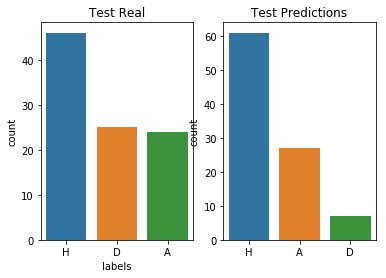

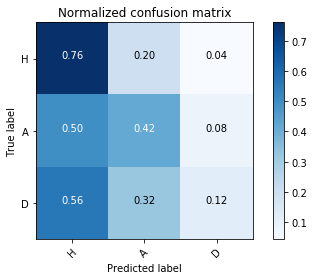

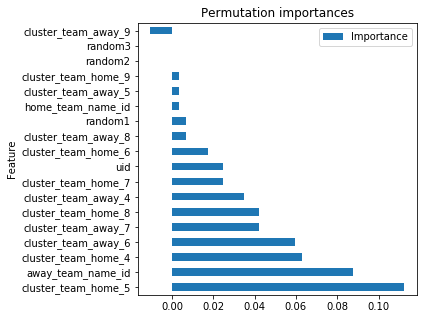

train_accuracy  test_accuracy  f1_score
0        0.589474       0.505263  0.465187


>>>  CLASSIFIER: svc

---------------------
*** ACCURACY ***
---------------------
Accuracy of svc classifier on training set: 0.97
Accuracy of svc classifier on test set: 0.46

---------------------
*** F1 SCORE ***
---------------------
F1 Score of svc classifier on test set: 0.34

---------------------
*** CONFUSION MATRIX ***
---------------------
Normalized confusion matrix


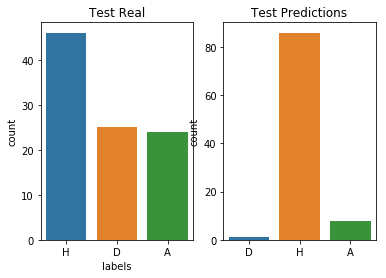

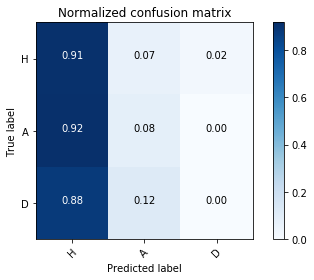

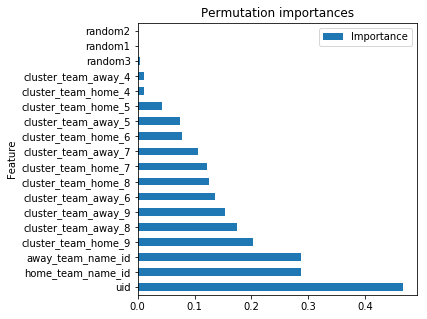

train_accuracy  test_accuracy  f1_score
0        0.968421       0.463158  0.339713


>>>  CLASSIFIER: rf

---------------------
*** ACCURACY ***
---------------------
Accuracy of rf classifier on training set: 0.78
Accuracy of rf classifier on test set: 0.49

---------------------
*** F1 SCORE ***
---------------------
F1 Score of rf classifier on test set: 0.46

---------------------
*** CONFUSION MATRIX ***
---------------------
Normalized confusion matrix


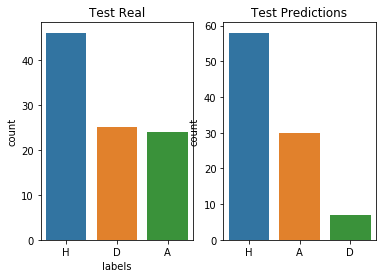

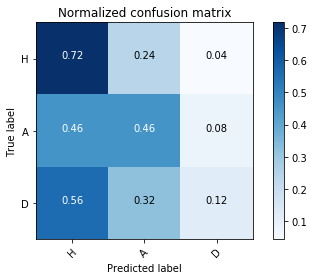

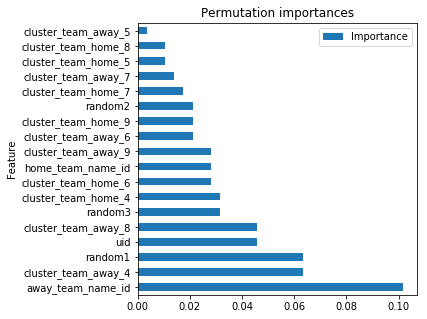

train_accuracy  test_accuracy  f1_score
0        0.782456       0.494737  0.459554

In [11]:
import nbimporter
import Building_models_function_to_import



categoric_types = df_testing_clustering.select_dtypes(include=['category','object']).columns.tolist()
categoric_types.remove('labels')
if categoric_types == []:
    categoric_types = [False]


import warnings
with warnings.catch_warnings():
# ignore all caught warnings
    warnings.filterwarnings("ignore")
    result, fi, df_wrong_predictions = Building_models_function_to_import.classifiers_performances(df_testing_clustering, scaler= False, onehot=[False], labelling= categoric_types, feature_importance = True)


['uid',
 'home_team_name_id',
 'away_team_name_id',
 'cluster_team_away_4',
 'cluster_team_home_4',
 'cluster_team_away_5',
 'cluster_team_home_5',
 'cluster_team_away_6',
 'cluster_team_home_6',
 'cluster_team_away_7',
 'cluster_team_home_7',
 'cluster_team_away_8',
 'cluster_team_home_8',
 'cluster_team_away_9',
 'cluster_team_home_9']

In [14]:
seasons_data = []
for season in seasons:
    seasons_data.append(season.replace('/','_').replace('20',''))

location_to_file = 'data/'
df_testing_clustering.to_csv(location_to_file+f'df_clustering_fifa_{leagues_id}_seasons_{seasons_data}.csv',index=False)